# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from IPython.display import Image

# magic word for producing visualizations in notebook
%matplotlib inline

import missingno as msno
from googletrans import Translator
import Levenshtein
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from tqdm import tqdm

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, roc_auc_score

'''
custom modules
'''
# function similar to Excel's vlookup
from vlookup import vlookup
# function to view all contents of a dataframe
from view_all import view_all
# function for the project
from section_1 import msno_overview
from section_2 import similar_feature, attribute_cat, str_to_num, ger_to_eng, pv_min_max, \
    pv_meaning_score, pv_verify_null
from section_3 import dataset_summary, view_feature
from section_4 import miss_val_summary

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 1. Load and overview

#### 1.1 azdias

In [2]:
'''
load and file overview
'''

azdias = pd.read_csv('../data/Udacity_AZDIAS_052018.csv', sep=';')

print (azdias.info())
azdias.head()

/var/folders/y5/wyn61d3n7wxdpg5j1f0rpvc80000gn/T/ipykernel_1227/3269094792.py:5: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('../data/Udacity_AZDIAS_052018.csv', sep=';')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


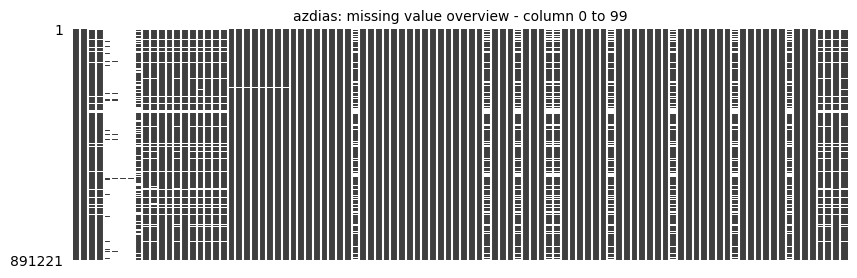

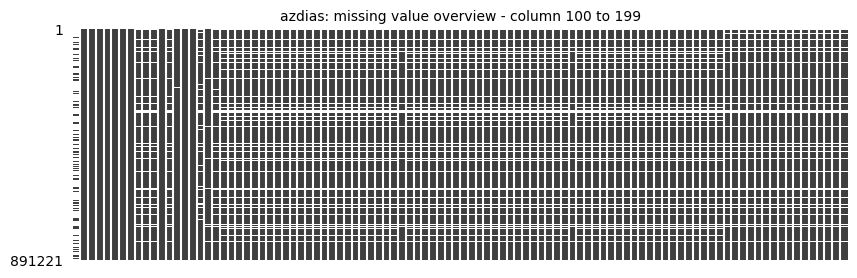

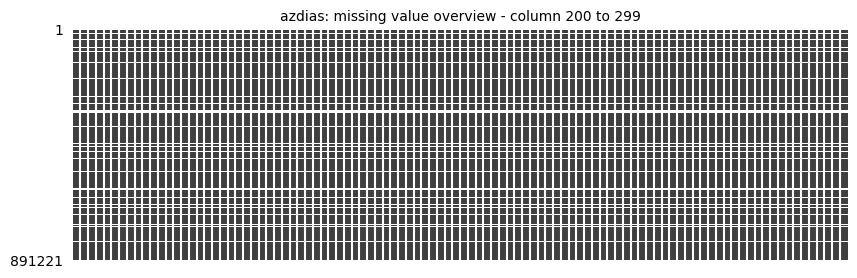

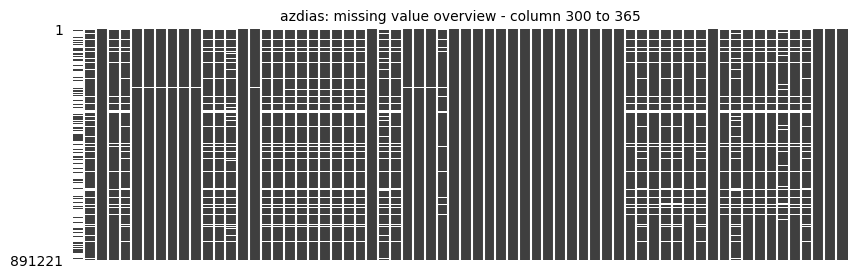

In [3]:
'''
missing value overview
'''

azdias.name = 'azdias'
msno_overview(azdias)

#### 1.2 customers

In [4]:
'''
load and file overview
'''

customers = pd.read_csv('../data/Udacity_CUSTOMERS_052018.csv', sep=';')
print (customers.info())
customers.head()

/var/folders/y5/wyn61d3n7wxdpg5j1f0rpvc80000gn/T/ipykernel_1227/2529495247.py:5: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('../data/Udacity_CUSTOMERS_052018.csv', sep=';')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


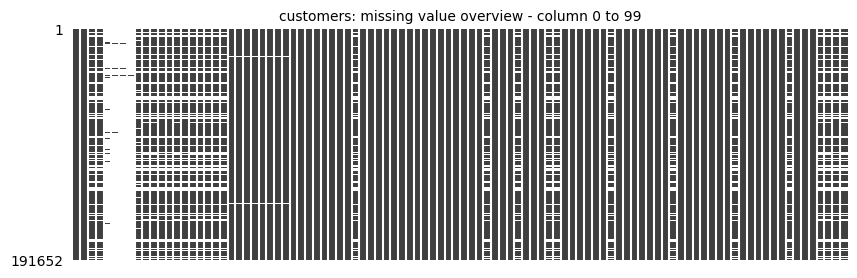

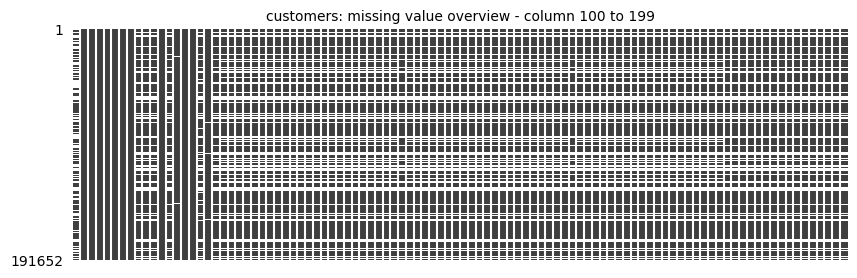

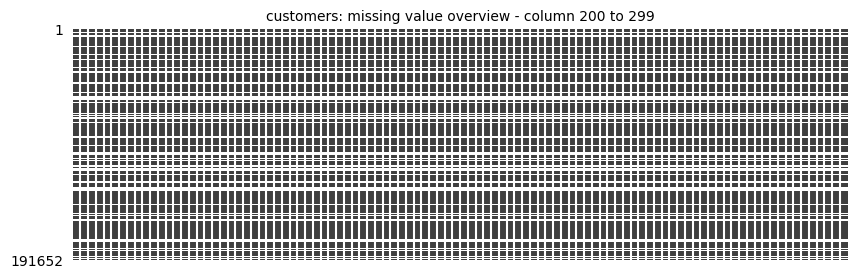

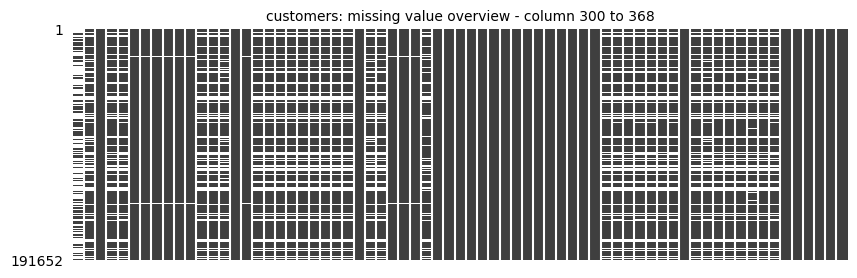

In [5]:
'''
missing value overview
'''

customers.name = 'customers'
msno_overview(customers)

#### 1.3 info

In [6]:
'''
load and overview
'''

ref_info = pd.read_excel(
    'DIAS Information Levels - Attributes 2017.xlsx', header=1).iloc[:, 1:]

# fillna on 'Information level' as values are only in the 1st rows
ref_info['Information level'] = ref_info['Information level'].fillna(method = 'ffill')

ref_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Information level  312 non-null    object
 1   Attribute          313 non-null    object
 2   Description        313 non-null    object
 3   Additional notes   20 non-null     object
dtypes: object(4)
memory usage: 9.9+ KB


#### 1.4 attr

In [7]:
'''
load and overview
'''

ref_attr = pd.read_excel(
    'DIAS Attributes - Values 2017.xlsx', header=1).iloc[:, 1:]

# rename 'Value' to 'Score' for easier documentation
ref_attr = ref_attr.rename(columns = {'Value' : 'Score'})

ref_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2258 entries, 0 to 2257
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Attribute    314 non-null    object
 1   Description  351 non-null    object
 2   Score        2258 non-null   object
 3   Meaning      2247 non-null   object
dtypes: object(4)
memory usage: 70.7+ KB


### 2. Baseline Understanding

There are 4 files given:
* 2 dataset files - azdias and customers
* 2 reference files - ref_info and ref_attr:  
  - ref_info is to explain dataset features in unreadable German acronyms  
  - ref_attr is to clarify the meanings of dataset Scores in numbers and acronyms.

This section aims to understand outlines of the 2 datasets and identify baseline factors.  
As the datasets do not have information on what column features and values exactly mean,  
this section focuses on the reference files that can help in understanding dataset contents.

#### 2.1 feature alignment

At first, the feature alignment of 4 given files is checked, and some features of reference files  
were modified for better alignment.

In [8]:
feature_dict = {
    'azdias' : set(azdias.columns.unique()),
    'customers' : set(customers.columns.unique()),
    'ref_info' : set(ref_info.Attribute.dropna().unique()),
    'ref_attr' : set(ref_attr.Attribute.dropna().unique()),
    }

print ('Number of features by file')
for k, v in feature_dict.items():
    print (k, ':', len(v))

Number of features by file
azdias : 366
customers : 369
ref_info : 313
ref_attr : 314


In [9]:
print ('Feature alignment - intersection & difference between files')
for i in range (0, 4):
    for j in range (0, 4):
        if i == j:
            continue
        
        key_1 = list(feature_dict.keys())[i]
        key_2 = list(feature_dict.keys())[j]
        set_1 = list(feature_dict.values())[i]
        set_2 = list(feature_dict.values())[j]
        
        intsec = set_1.intersection(set_2)
        ft_diff = set_1 - set_2
        feature_dict[f'{key_1}_intsec_{key_2}'] = intsec
        feature_dict[f'in_{key_1}_notin_{key_2}'] = ft_diff
        
        intsec_print = f'{key_1} & {key_2} intersection:'
        ft_diff_print = f' /  in {key_1} & not-in {key_2}:'        
        print (intsec_print, str(len(intsec)).rjust(41 - len(intsec_print)),
               ft_diff_print, str(len(ft_diff)).rjust(40 - len(ft_diff_print)))

Feature alignment - intersection & difference between files
azdias & customers intersection:       366  /  in azdias & not-in customers:       0
azdias & ref_info intersection:        264  /  in azdias & not-in ref_info:      102
azdias & ref_attr intersection:        272  /  in azdias & not-in ref_attr:       94
customers & azdias intersection:       366  /  in customers & not-in azdias:       3
customers & ref_info intersection:     264  /  in customers & not-in ref_info:   105
customers & ref_attr intersection:     272  /  in customers & not-in ref_attr:    97
ref_info & azdias intersection:        264  /  in ref_info & not-in azdias:       49
ref_info & customers intersection:     264  /  in ref_info & not-in customers:    49
ref_info & ref_attr intersection:      300  /  in ref_info & not-in ref_attr:     13
ref_attr & azdias intersection:        272  /  in ref_attr & not-in azdias:       42
ref_attr & customers intersection:     272  /  in ref_attr & not-in customers:    42
ref_a

* modify ref_info features

In [10]:
'''
from 369 features of customers, 105 features are not in ref_attr
and in most cases the suffix of _RZ is causing mismatch
'''

info_customers_similarity = similar_feature(
    'in_ref_info_notin_customers', 'in_customers_notin_ref_info', feature_dict)
info_customers_similarity.head()

,Attribute,in_customers_notin_ref_info,distance,suffix_added
0,D19_TIERARTIKEL_RZ,D19_TIERARTIKEL,3,1
1,D19_SONSTIGE_RZ,D19_SONSTIGE,3,1
2,D19_VERSAND_REST_RZ,D19_VERSAND_REST,3,1
3,D19_HANDWERK_RZ,D19_HANDWERK,3,1
4,D19_BANKEN_REST_RZ,D19_BANKEN_REST,3,1


In [11]:
'''
remove _RZ suffix from ref_info.Attribute
'''
org_info = ref_info.copy()
info_customers_similarity = info_customers_similarity.query('Attribute.str.len() > 5')

ref_col = 'in_customers_notin_ref_info'
ref_info = vlookup(ref_info, info_customers_similarity, lookup_col = ref_col)
ref_info.Attribute = np.where(ref_info[ref_col].isna(), ref_info.Attribute, ref_info[ref_col])
ref_info = ref_info.drop(ref_col, axis = 1)

* modify ref_attr features

In [12]:
'''
from 369 features of customers, 97 features are not in ref_attr
and in most cases the suffix of _RZ is causing mismatch
'''

attr_customers_similarity = similar_feature(
    'in_ref_attr_notin_customers', 'in_customers_notin_ref_attr', feature_dict)
attr_customers_similarity.head()

,Attribute,in_customers_notin_ref_attr,distance,suffix_added
0,D19_TIERARTIKEL_RZ,D19_TIERARTIKEL,3,1
1,D19_SONSTIGE_RZ,D19_SONSTIGE,3,1
2,D19_VERSAND_REST_RZ,D19_VERSAND_REST,3,1
3,D19_HANDWERK_RZ,D19_HANDWERK,3,1
4,D19_BANKEN_REST_RZ,D19_BANKEN_REST,3,1


In [13]:
'''
remove _RZ suffix from ref_attr.Attribute
'''
org_attr = ref_attr.copy()
attr_customers_similarity = attr_customers_similarity.query('Attribute.str.len() > 8')

ref_col = 'in_customers_notin_ref_attr'
ref_attr = vlookup(ref_attr, attr_customers_similarity, lookup_col = ref_col)
ref_attr.Attribute = np.where(ref_attr[ref_col].isna(), ref_attr.Attribute, ref_attr[ref_col])
ref_attr = ref_attr.drop(ref_col, axis = 1)

* improved alignment

In [14]:
feature_dict['ref_info'] = set(ref_info.Attribute.dropna().unique())
feature_dict['ref_attr'] = set(ref_attr.Attribute.dropna().unique())

print ('Feature alignment - intersection & difference between files')
for i in range (0, 4):
    for j in range (0, 4):
        if i == j:
            continue
        
        key_1 = list(feature_dict.keys())[i]
        key_2 = list(feature_dict.keys())[j]
        set_1 = list(feature_dict.values())[i]
        set_2 = list(feature_dict.values())[j]
        
        intsec = set_1.intersection(set_2)
        ft_diff = set_1 - set_2
        feature_dict[f'{key_1}_intsec_{key_2}'] = intsec
        feature_dict[f'in_{key_1}_notin_{key_2}'] = ft_diff
        
        intsec_print = f'{key_1} & {key_2} intersection:'
        ft_diff_print = f' /  in {key_1} & not-in {key_2}:'        
        print (intsec_print, str(len(intsec)).rjust(41 - len(intsec_print)),
               ft_diff_print, str(len(ft_diff)).rjust(40 - len(ft_diff_print)))

Feature alignment - intersection & difference between files
azdias & customers intersection:       366  /  in azdias & not-in customers:       0
azdias & ref_info intersection:        299  /  in azdias & not-in ref_info:       67
azdias & ref_attr intersection:        308  /  in azdias & not-in ref_attr:       58
customers & azdias intersection:       366  /  in customers & not-in azdias:       3
customers & ref_info intersection:     299  /  in customers & not-in ref_info:    70
customers & ref_attr intersection:     308  /  in customers & not-in ref_attr:    61
ref_info & azdias intersection:        299  /  in ref_info & not-in azdias:       14
ref_info & customers intersection:     299  /  in ref_info & not-in customers:    14
ref_info & ref_attr intersection:      300  /  in ref_info & not-in ref_attr:     13
ref_attr & azdias intersection:        308  /  in ref_attr & not-in azdias:        6
ref_attr & customers intersection:     308  /  in ref_attr & not-in customers:     6
ref_a

#### 2.2 refine reference files

To establish baseline understanding on the structure of the 2 dataset files,  
ref_info is upgraded to feature_desc containing all features of customers  
and explanations in detail.  
And ref_attr is cleaned to minimize mismatches with dataset values.

* upgrade ref_info to feature_desc

In [15]:
'''
feature_desc with all features of customers and information added from ref_info 
'''

feature_desc = pd.DataFrame(customers.columns, columns=['Attribute'])
feature_desc = vlookup(feature_desc, ref_info, 'Attribute')

'''
To fill in missing descriptions, some values were added from attr and translation columns
were created using googletrans.
The result is saved in the root folder as Excel due to the time-consuming code execution.
'''
# # for Attribute without Description, add 12 Description values from ref_attr
# feature_desc = vlookup(feature_desc, ref_attr, 'Attribute', 'Description', intsec = 'update')

# # add category of Attribute
# feature_desc = attribute_cat(feature_desc)

# # add translated information to Desc
# feature_desc['eng_Desc'] = np.where(
#     feature_desc.Description.isna(),
#     feature_desc.Attribute.str.replace('_', ' ').apply(ger_to_eng),
#     np.nan)
# feature_desc['Desc'] = feature_desc.Description.fillna('') + feature_desc.eng_Desc.fillna('')

# # column order
# feature_desc = feature_desc[[
#     'category_large', 'category_small', 'Attribute', 'Information level', 'Additional notes', 'Description', 'Desc']]

feature_desc = pd.read_excel('feature_desc.xlsx', index_col = [0])
print(feature_desc.info())
feature_desc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369 entries, 0 to 368
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category_large     369 non-null    object
 1   category_small     369 non-null    object
 2   Attribute          369 non-null    object
 3   Information level  298 non-null    object
 4   Additional notes   18 non-null     object
 5   Description        312 non-null    object
 6   Desc               369 non-null    object
dtypes: object(7)
memory usage: 23.1+ KB
None


,category_large,category_small,Attribute,Information level,Additional notes,Description,Desc
0,no_category,LNR,LNR,NaN,NaN,NaN,LNR
1,AGER,AGER,AGER_TYP,NaN,in cooperation with Kantar TNS; the informatio...,best-ager typology,best-ager typology
2,AKT,AKT,AKT_DAT_KL,NaN,NaN,NaN,Act Dat KL
3,ALTER,ALTER,ALTER_HH,Household,NaN,main age within the household,main age within the household
4,ALTER,ALTER,ALTER_KIND1,NaN,NaN,NaN,Old child1


* clean ref_attr

In [16]:
'''
change numbers in string form to integer
'''
# 2 numbers in 1 str value
ref_attr.Score = ref_attr.Score.apply(
    lambda x: [int(i) for i in x.split(',')] if isinstance(x, str) and ',' in x else x)
ref_attr = ref_attr.explode('Score').reset_index(drop=True)
# '-1' to -1
ref_attr.Score = ref_attr.Score.apply(str_to_num)

'''
merge add-on information in some cells below Description
'''
# create attribute and description_shift with shift(-1)
ref_attr['attribute_shift'] = ref_attr.Attribute.shift(-1).fillna('')
ref_attr['description_shift'] = ref_attr.Description.shift(-1).fillna('')

# merge Description and add-on
ref_attr.Description = ref_attr.Description.mask(
    (~(ref_attr['Attribute'].isna()) & (ref_attr['attribute_shift'].isna())),
    ref_attr.Description + ' ' + ref_attr.description_shift)

# replace add-on with np.nan
ref_attr.Description = ref_attr.Description.mask(
    (ref_attr['Attribute'].isna()) & ~(ref_attr['Description'].isna()),
    np.nan)
# drop description shift
ref_attr = ref_attr.drop(['attribute_shift', 'description_shift'], axis = 1)

'''
fill in blank cells with corresponding values as only 1st lines
of Attribute & Description have values
'''

ref_attr[['Attribute', 'Description']] = ref_attr[
    ['Attribute', 'Description']].fillna(method = 'ffill')

'''
keep 308 intersection features between ref_attr and datasets,
and drop exclusive features of datasets that are not useful at this stage
'''

ref_attr = ref_attr[ref_attr.Attribute.isin(feature_dict['ref_attr_intsec_customers'])] # query not working

ref_attr = attribute_cat(ref_attr)
ref_attr = ref_attr[['category_large', 'category_small', 'Attribute', 'Description', 'Score', 'Meaning']]

print (f'number of Attribute: {ref_attr.Attribute.nunique()}')
ref_attr.head()

number of Attribute: 308


,category_large,category_small,Attribute,Description,Score,Meaning
0,AGER,AGER,AGER_TYP,best-ager typology,-1,unknown
1,AGER,AGER,AGER_TYP,best-ager typology,0,no classification possible
2,AGER,AGER,AGER_TYP,best-ager typology,1,passive elderly
3,AGER,AGER,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER,AGER,AGER_TYP,best-ager typology,3,experience-driven elderly


#### 2.3 pre-study on dataset contents

After identifying the dataset structure in 2.1 and 2.2 above, 2.3 focuses more on examining  
the dataset contents.  
Throughout pre-study on Score values of datasets, various aspects including the ranges  
of feature Scores, missing values, data types, etc. are verified.

* create pre-study dataframes by value form of Score

In [17]:
'''
add delimiter column Score_form
'''

ref_attr = ref_attr.copy() # to avoid SettingWithCopyWarning
ref_attr['Score_form'] = ref_attr.Score.map(type)
ref_attr.Score_form.value_counts()

<class 'int'>    2256
<class 'str'>      53
Name: Score_form, dtype: int64

In [18]:
'''
attr_num containing Scores denoted in number
'''

attr_num = ref_attr[ref_attr.Score_form == int].copy()
print (f'number of Attribute(s): {attr_num.Attribute.nunique()}')

number of Attribute(s): 300


In [19]:
'''
attr_str containing Scores denoted in string
'''

attr_str = ref_attr[ref_attr.Score_form == str].copy()
print (f'number of Attribute(s): {attr_str.Attribute.nunique()}')

number of Attribute(s): 9


In [20]:
'''
there is 1 feature that Scores are in both numeric and string forms
'''

set(attr_num.Attribute.unique()).intersection(set(attr_str.Attribute.unique()))

{'OST_WEST_KZ'}

##### 2.3.1 ref_attr Scores denoted in number

From analyses on attr_num containing Score values in integer type, the following are found:
* All features in att_num are discrete
* Some Score values should be pre-processed as missing value (noted in dictionary p_processing)

In [21]:
'''
to initiate analyses, make summary of attr_num min/max values
'''

attr_num_score = pv_min_max(attr_num, feature_desc)
attr_num_score.head()

number of Attribute(s): 300
['-1 to -1' '-1 to 15' '-1 to 2' '-1 to 3' '-1 to 4' '-1 to 5' '-1 to 55'
 '-1 to 6' '-1 to 7' '-1 to 8' '-1 to 9' '0 to 1' '0 to 10' '0 to 21'
 '0 to 5' '0 to 6' '0 to 7' '1 to 10' '1 to 11' '1 to 12' '1 to 40'
 '1 to 5' '1 to 6' '1 to 7' '1 to 9']


,category_large,Attribute,Description,Desc,Additional notes,min,max,min_max_cat
0,OST,OST_WEST_KZ,flag indicating the former GDR/FRG,flag indicating the former GDR/FRG,no_info,-1,-1,-1 to -1
1,PRAEGENDE,PRAEGENDE_JUGENDJAHRE,dominating movement in the person's youth (ava...,dominating movement in the person's youth (ava...,own typology modelled on different AZ DIAS data,-1,15,-1 to 15
2,KBA05,KBA05_ANTG4,number of >10 family houses in the cell,number of >10 family houses in the cell,no_info,-1,2,-1 to 2
3,VERS,VERS_TYP,insurance typology,insurance typology,in cooperation with TNS Infratest,-1,2,-1 to 2
4,ANREDE,ANREDE_KZ,gender,gender,no_info,-1,2,-1 to 2


* All features in att_num are discrete

In [22]:
'''
check features that have min/max Score gap over 10

features with min/max Score gap 10 or below are undoubtedly discrete.  
6 features that have min/max Score gap over 10 are also found to be discrete  
from Meaning values below.
'''

temp_over10_attribute = attr_num_score[
    (attr_num_score['max'] - attr_num_score['min']) > 10].Attribute.unique()

temp_over10 = pv_meaning_score(
    attr_num.query('Attribute in @temp_over10_attribute'), feature_desc)

number of Attribute(s): 6


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,ALTER,ALTER_HH,main age within the household,main age within the household,no_info,"[unknown / no main age detectable, 01.01.1895 bis 31.12.1899, 01.01.1900 bis 31.12.1904, 01.01.1905 bis 31.12.1909, 01.01.1910 bis 31.12.1914, 01.01.1915 bis 31.12.1919, 01.01.1920 bis 31.12.1924, 01.01.1925 bis 31.12.1929, 01.01.1930 bis 31.12.1934, 01.01.1935 bis 31.12.1939, 01.01.1940 bis 31.12.1944, 01.01.1945 bis 31.12.1949, 01.01.1950 bis 31.12.1954, 01.01.1955 bis 31.12.1959, 01.01.1960 bis 31.12.1964, 01.01.1965 bis 31.12.1969, 01.01.1970 bis 31.12.1974, 01.01.1975 bis 31.12.1979, 01.01.1980 bis 31.12.1984, 01.01.1985 bis 31.12.1989, 01.01.1990 bis 31.12.1994, 01.01.1995 bis 31.12.1999]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]"
1,CAMEO,CAMEO_INTL_2015,CAMEO classification 2015 - international typology,CAMEO classification 2015 - international typology,no_info,"[unknown, Wealthy Households-Pre-Family Couples & Singles, Wealthy Households-Young Couples With Children, Wealthy Households-Families With School Age Children, Wealthy Households-Older Families & Mature Couples, Wealthy Households-Elders In Retirement, Prosperous Households-Pre-Family Couples & Singles, Prosperous Households-Young Couples With Children, Prosperous Households-Families With School Age Children, Prosperous Households-Older Families & Mature Couples, Prosperous Households-Elders In Retirement, Comfortable Households-Pre-Family Couples & Singles, Comfortable Households-Young Couples With Children, Comfortable Households-Families With School Age Children, Comfortable Households-Older Families & Mature Couples, Comfortable Households-Elders In Retirement, Less Affluent Households-Pre-Family Couples & Singles, Less Affluent Households-Young Couples With Children, Less Affluent Households-Families With School Age Children, Less Affluent Households-Older Families & Mature Couples, Less Affluent Households-Elders In Retirement, Poorer Households-Pre-Family Couples & Singles, Poorer Households-Young Couples With Children, Poorer Households-Families With School Age Children, Poorer Households-Older Families & Mature Couples, Poorer Households-Elders In Retirement]","[-1, 11, 12, 13, 14, 15, 21, 22, 23, 24, 25, 31, 32, 33, 34, 35, 41, 42, 43, 44, 45, 51, 52, 53, 54, 55]"
2,GFK,GFK_URLAUBERTYP,vacation habits,vacation habits,no_info,"[Event travelers, Family-oriented vacationists, Winter sportspeople, Culture lovers, Nature fans, Hiker, Golden ager, Homeland-connected vacationists , Package tour travelers, Connoisseurs, Active families, without vacation]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
3,LP,LP_LEBENSPHASE_FEIN,lifestage fine,lifestage fine,modelled on different AZ DIAS data,"[single low-income earners of younger age, single low-income earners of middle age, single average earners of younger age , single average earners of middle age, single low-income earners of advanced age, single low-income earners at retirement age , single average earners of advanced age, single average earners at retirement age, single independant persons, wealthy single homeowners, single homeowners of advanced age, single homeowners at retirement age, single top earners of higher age , low-income- and average earner-couples of younger age, low-income earner-couples of higher age, average earner-couples of higher age , independant couples, wealthy homeowner-couples of younger age , homeowner-couples of higher age, top earner-couples of higher age, single parent low-income earners, single parent average earners, single parent high-income earners, low-income earner-families, average earner-families , independant families, homeowner-families, top earner-families, low-income earners of younger age from mulitperson households, average earners of younger age from mulitperson households, low-income earners of higher age from mulitperson households, average earners of higher age from mul

* Pre-processing items when Meaning value is 'unknown'

In [23]:
'''
when Meaning value is 'unknown', there are 3 score values
'''

ref_attr.query('Meaning == "unknown"').Score.unique()

array([-1, 0, 9], dtype=object)

In [24]:
'''
when Score value is -1, the meaning is 100% unknown,
which should be regarded as missing value in pre-processing
'''

attr_num.query('Score < 0').Meaning.value_counts()

unknown    224
Name: Meaning, dtype: int64

In [25]:
'''
NOTE dict p_process to note points to be pre-processed
'''

p_process = {'2.3.1-minus1' : 'replace / All / {-1: np.nan}'}

In [26]:
'''
when Score value is 0 or 9, there are various Meaning values,
that they need further analyses
'''
print (attr_num.query('Score == 0').Meaning.unique())
print (attr_num.query('Score == 9').Meaning.unique())

['no classification possible' 'unknown' 'unknown / no main age detectable'
 'no transactions known' 'no transaction known'
 'no Online-transactions within the last 12 months'
 "doesn't belong to the green avantgarde" 'classification not possible'
 'none' 'no 1-2 family homes' 'no 3-5 family homes' 'no 6-10 family homes'
 'no >10 family homes' 'external supplied hedonists '
 'no score calculated']
['uniformly distributed' '01.01.1935 bis 31.12.1939' 'urban working class'
 'activity elder than 3 years' 'activity elder than 36 months'
 '90% Online-transactions within the last 12 months' 'Inactive'
 'Package tour travelers' 'unknown' 'shared flat' 'multiperson household'
 'single independant persons'
 'average earners of younger age from mulitperson households'
 'houseowners' nan '> 700.000  inhabitants'
 '70ies - peace movement (Avantgarde, O+W)'
 'length of residence more than 10 years']


In [27]:
'''
when Score value is 0 and Meaning value is unknown
there are 12 category_large values
'''

unknown_0 = attr_num.query('Score == 0 and Meaning == "unknown"').category_large.unique()
print ('category_large values when Score value is 0 and Meaning value is unknown:', '\n', unknown_0, '.\n')

'''
but some of these category_large values have multiple meaning values
corresponding to Score value 0, that the condition of Score value 0
is not suitable for a pre-processing item.
'''

print ('cases of 12 category_large values when Score value 0 are showing multile Meaning values:')
attr_num.query(
    'category_large in (@unknown_0) and Score == 0 and Meaning != "unknown"').head()

category_large values when Score value is 0 and Meaning value is unknown: 
 ['ALTERSKATEGORIE' 'ANREDE' 'CJT' 'no_category' 'HH' 'KBA05'
 'NATIONALITAET' 'PRAEGENDE' 'RETOURTYP' 'TITEL' 'WOHNDAUER' 'W'] .

cases of 12 category_large values when Score value 0 are showing multile Meaning values:


,category_large,category_small,Attribute,Description,Score,Meaning,Score_form
773,KBA05,KBA05,KBA05_ALTER1,share of car owners less than 31 years old,0,none,<class 'int'>
794,KBA05,KBA05,KBA05_ALTER4,share of cars owners elder than 61 years,0,none,<class 'int'>
802,KBA05,KBA05,KBA05_ANHANG,share of trailers in the microcell,0,none,<class 'int'>
807,KBA05,KBA05,KBA05_ANTG1,number of 1-2 family houses in the cell,0,no 1-2 family homes,<class 'int'>
813,KBA05,KBA05,KBA05_ANTG2,number of 3-5 family houses in the cell,0,no 3-5 family homes,<class 'int'>


In [28]:
'''
when Score value is 9 and Meaning value is unknown
there are 4 category_small values
'''

unknown_9 = attr_num.query('Score == 9 and Meaning == "unknown"').category_small.unique()
print ('category_small values when Score value is 9 and Meaning value is unknown:', '\n', unknown_9, '\n')

'''
these category_small values always have Meaning value as unknown
when Score value is 9. this should be regarded as a pre-processing item.  
'''

print ('cases of 4 category_small values when Score value 9 and Meaning value is NOT unknown:')
attr_num.query('category_small in (@unknown_9) and Score == 9 and Meaning != "unknown"')

category_small values when Score value is 9 and Meaning value is unknown: 
 ['KBA05' 'RELAT' 'SEMIO' 'ZABEOTYP'] 

cases of 4 category_small values when Score value 9 and Meaning value is NOT unknown:


,category_large,category_small,Attribute,Description,Score,Meaning,Score_form


In [29]:
'''
NOTE pre-processing items
'''

p_process['2.3.1-unknown_9'] = 'mask / category_small in unknown_9 / Score 9 to -1'

* Pre-processing items when Meaning value is other than 'unknown'

In [30]:
'''
include 4 Score values undoubtedly meaning null into to_null,  
and other Score values possibly meaning null into maybe_null
'''

to_null = ['unknown', 'unknown / no main age detectable']
maybe_null = ['none', 'no classification possible', 'classification not possible',
              'Inactive', 'no transaction known', 'no transactions known']

'''
All Meaning values in maybe_null are not found suitable for pre-processing
from Meaning values below.
'''
for i in maybe_null:
    print (i)
    verify_maybe_null = pv_verify_null(attr_num, feature_desc, i)

none
number of Attribute(s): 138


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,KBA05,KBA05_ALTER1,share of car owners less than 31 years old,share of car owners less than 31 years old,no_info,"[unknown, unknown, none, low, average, high, very high]","[-1, 9, 0, 1, 2, 3, 4]"
1,KBA05,KBA05_ALTER4,share of cars owners elder than 61 years,share of cars owners elder than 61 years,no_info,"[unknown, unknown, none, very low, low, average, high, very high]","[-1, 9, 0, 1, 2, 3, 4, 5]"
2,KBA05,KBA05_ANHANG,share of trailers in the microcell,share of trailers in the microcell,no_info,"[unknown, unknown, none, some, some more, very many]","[-1, 9, 0, 1, 2, 3]"
3,KBA05,KBA05_CCM4,share of cars with more than 2499ccm,share of cars with more than 2499ccm,no_info,"[unknown, unknown, none, low, average, high, very high]","[-1, 9, 0, 1, 2, 3, 4]"
4,KBA05,KBA05_DIESEL,share of cars with Diesel-engine in the microcell,share of cars with Diesel-engine in the microcell,no_info,"[unknown, unknown, none, very low, low, average, high]","[-1, 9, 0, 1, 2, 3, 4]"


no classification possible
number of Attribute(s): 1


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,AGER,AGER_TYP,best-ager typology,best-ager typology,in cooperation with Kantar TNS; the information basis is a consumer survey,"[unknown, no classification possible, passive elderly, cultural elderly, experience-driven elderly]","[-1, 0, 1, 2, 3]"


classification not possible
number of Attribute(s): 1


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,HEALTH,HEALTH_TYP,health typology,health typology,in cooperation with Kantar TNS; the information basis is a consumer survey,"[unknown, classification not possible, critical reserved , sanitary affine , jaunty hedonists ]","[-1, 0, 1, 2, 3]"


Inactive
number of Attribute(s): 1


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,D19,D19_KONSUMTYP,consumption type,consumption type,no_info,"[Universal, Versatile, Gourmet, Family, Informed , Modern, Inactive]","[1, 2, 3, 4, 5, 6, 9]"


no transaction known
number of Attribute(s): 34


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,D19,D19_BANKEN_DIREKT,transactional activity based on the product group DIRECT BANKS,transactional activity based on the product group DIRECT BANKS,"AZ has access to approx. 650 Million transaction data - this is the basis for the criteria family DHT4A aka. D19. This data contains unique data regarding the mail-order activity of consumers, differentiated","[no transaction known, Multibuyer 0-12 months, Doublebuyer 0-12 months, Singlebuyer 0-12 months, Multi-/Doublebuyer 13-24 months, Singlebuyer 13-24 months, Buyer > 24 months, Prospects > 24 months]","[0, 1, 2, 3, 4, 5, 6, 7]"
1,D19,D19_BANKEN_GROSS,transactional activity based on the product group BIG BANKS,transactional activity based on the product group BIG BANKS,no_info,"[no transaction known, Multibuyer 0-12 months, Doublebuyer 0-12 months, Singlebuyer 0-12 months, Multi-/Doublebuyer 13-24 months, Singlebuyer 13-24 months, Buyer > 24 months, Prospects > 24 months]","[0, 1, 2, 3, 4, 5, 6, 7]"
2,D19,D19_BANKEN_LOKAL,transactional activity based on the product group LOCAL BANKS,transactional activity based on the product group LOCAL BANKS,no_info,"[no transaction known, Multibuyer 0-12 months, Doublebuyer 0-12 months, Singlebuyer 0-12 months, Multi-/Doublebuyer 13-24 months, Singlebuyer 13-24 months, Buyer > 24 months, Prospects > 24 months]","[0, 1, 2, 3, 4, 5, 6, 7]"
3,D19,D19_BANKEN_REST,transactional activity based on the product group FURTHER BANKS,transactional activity based on the product group FURTHER BANKS,no_info,"[no transaction known, Multibuyer 0-12 months, Doublebuyer 0-12 months, Singlebuyer 0-12 months, Multi-/Doublebuyer 13-24 months, Singlebuyer 13-24 months, Buyer > 24 months, Prospects > 24 months]","[0, 1, 2, 3, 4, 5, 6, 7]"
4,D19,D19_BEKLEIDUNG_GEH,transactional activity based on the product group LUXURY CLOTHING,transactional activity based on the product group LUXURY CLOTHING,no_info,"[no transaction known, Multibuyer 0-12 months, Doublebuyer 0-12 months, Singlebuyer 0-12 months, Multi-/Doublebuyer 13-24 months, Singlebuyer 13-24 months, Buyer > 24 months, Prospects > 24 months]","[0, 1, 2, 3, 4, 5, 6, 7]"


no transactions known
number of Attribute(s): 22


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,D19,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,transaction activity BANKS in the last 12 months,no_info,"[no transactions known, very low activity, low activity, slightly increased activity, increased activity, high activity, very high activity]","[0, 1, 2, 3, 4, 5, 6]"
1,D19,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,transaction activity BANKS in the last 24 months,no_info,"[no transactions known, very low activity, low activity, slightly increased activity, increased activity, high activity, very high activity]","[0, 1, 2, 3, 4, 5, 6]"
2,D19,D19_BANKEN_DATUM,actuality of the last transaction for the segment banks TOTAL,actuality of the last transaction for the segment banks TOTAL,no_info,"[highest activity within the last 12 months, very high activity within the last 12 months, high activity within the last 12 months, increased activity within the last 12 months, slightly increased activity within the last 12 months, activity elder than 1 year, activity elder than 1,5 years, activity elder than 2 years, activity elder than 3 years, no transactions known]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
3,D19,D19_BANKEN_OFFLINE_DATUM,actuality of the last transaction for the segment banks OFFLINE,actuality of the last transaction for the segment banks OFFLINE,no_info,"[highest activity within the last 12 months, very high activity within the last 12 months, high activity within the last 12 months, increased activity within the last 12 months, slightly increased activity within the last 12 months, activity elder than 12 months, activity elder than 18 months, activity elder than 24 months, activity elder than 36 months, no transactions known]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"
4,D19,D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segment banks ONLINE,actuality of the last transaction for the segment banks ONLINE,no_info,"[highest activity within the last 12 months, very high activity within the last 12 months, high activity within the last 12 months, increased activity within the last 12 months, slightly increased activity within the last 12 months, activity elder than 12 months, activity elder than 18 months, activity elder than 24 months, activity elder than 36 months, no transactions known]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]"


In [31]:
'''
NOTE pre-processing items
'''

p_process['2.3.1-to_null'] = 'mask / All / replace Score to null if corresponding Meaning is in to_null'

##### 2.3.2 ref_attr Scores denoted in string

From analyses on 9 attr_str containing Score values in string type,
7 features are found as continuous

In [32]:
'''
to initiate analyses, make summary of attr_str with Meaning and Score values
'''

attr_str_score = pv_meaning_score(attr_str, feature_desc, display = False)
view_all(attr_str_score)

number of Attribute(s): 9


,category_large,Attribute,Description,Desc,Additional notes,Meaning,Score
0,ANZ,ANZ_HAUSHALTE_AKTIV,number of households in the building,number of households in the building,no_info,[numeric value (typically coded from 1-10)],[…]
1,ANZ,ANZ_HH_TITEL,number of academic title holder in building,number of academic title holder in building,no_info,[numeric value (typically coded from 1-10)],[…]
2,ANZ,ANZ_PERSONEN,number of adult persons in the household,number of adult persons in the household,no_info,[numeric value (typically coded from 1-3)],[…]
3,ANZ,ANZ_TITEL,number of professional title holder in household,number of professional title holder in household,no_info,[numeric value (typically coded from 1-10)],[…]
4,CAMEO,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classification,CAMEO classification 2015 - detailled classification,no_info,"[Work-Life-Balance, Wealthy Best Ager, Successful Songwriter, Old Nobility, City Nobility, Cottage Chic, Noble Jogger, Established gourmet, Fine Management, Career & Family, Powershopping Families, Rural Neighborhood, Secure Retirement, Family Starter, Family Life, String Trimmer, Empty Nest, Golden Ager, Younger Employees, Suddenly Family, Family First, Stock Market Junkies, Coffee Rider, Active Retirement, Jobstarter, Petty Bourgeois, Long-established, Sportgardener, Urban Parents, Frugal Aging, Journeymen, Mantaplatte, Factory Worker, Rear Window, Interested Retirees, Multi-culteral, Young & Mobile, Prefab, Town Seniors, First Shared Apartment, Temporary Workers, Afternoon Talk Show, Mini-Jobber, Socking Away]","[1A, 1B, 1C, 1D, 1E, 2A, 2B, 2C, 2D, 3A, 3B, 3C, 3D, 4A, 4B, 4C, 4D, 4E, 5A, 5B, 5C, 5D, 5E, 5F, 6A, 6B, 6C, 6D, 6E, 6F, 7A, 7B, 7C, 7D, 7E, 8A, 8B, 8C, 8D, 9A, 9B, 9C, 9D, 9E]"
5,KBA13,KBA13_ANZAHL_PKW,number of cars in the PLZ8,number of cars in the PLZ8,no_info,[numeric value],[…]
6,MIN,MIN_GEBAEUDEJAHR,year the building was first mentioned in our database,year the building was first mentioned in our database,no_info,[numeric value],[…]
7,OST,OST_WEST_KZ,flag indicating the former GDR/FRG,flag indicating the former GDR/FRG,no_info,"[East (GDR), West (FRG)]","[O, W]"
8,no_category,GEBURTSJAHR,year of birth,year of birth,no_info,[numeric value],[…]


* 7 features are found as continuous

In [33]:
'''
7 found as continuous to be checked in detail in the next section.
'''
pre_study_continuous = list(
    attr_str_score[attr_str_score.Score.apply(lambda x: x == ['…'])].Attribute.unique())

### 3. Dataset exploration

Based on framework findings from section 2, section 3 is dealing with actual datasets.  
In this section, similar steps taken in the previous section will be repeated to fine-tune  
and finalize pro-processing items.

In [34]:
'''
create a concatenated dataframe of 2 datasets for temporary use
'''

concat_data = pd.concat([customers, azdias], axis=0).reset_index(drop = True)
concat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082873 entries, 0 to 1082872
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(268), int64(93), object(8)
memory usage: 3.0+ GB


In [35]:
'''
datasets containing intersection features in both of datasets and ref_attr
'''

datasets = concat_data[
    list(feature_dict['customers_intsec_ref_attr'])].copy()
datasets.shape

(1082873, 308)

In [36]:
'''
datasets_excl containing exclusive features of datasets
'''

datasets_excl = concat_data[
    list(feature_dict['in_customers_notin_ref_attr'])].copy()
datasets_excl.shape

(1082873, 61)

#### 3.1 intersection features in both of datasets and ref_attr

##### 3.1.1 numeric dataset Scores of intersection features

In [37]:
'''
make datasets_num_score containing summary of numeric Score values
'''

datasets_num_score = dataset_summary(datasets, feature_desc, ['int', 'float'])

number of Attribute(s): 304


,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat
0,KBA05_ZUL1,893569.0,3.053233,1.305466,1.0,2.0,3.0,4.0,9.0,share of cars built before 1994,0.174816,1 to 9
1,KBA13_HALTER_40,925792.0,3.080517,1.086585,1.0,2.0,3.0,4.0,5.0,share of car owners between 36 and 40 within the PLZ8,0.145059,1 to 5
2,KBA05_CCM4,893569.0,1.386863,1.587412,0.0,0.0,1.0,2.0,9.0,share of cars with more than 2499ccm,0.174816,0 to 9
3,KBA13_SEG_SPORTWAGEN,925792.0,2.626002,1.445313,0.0,2.0,3.0,3.0,5.0,share of sportscars within the PLZ8,0.145059,0 to 5
4,FINANZ_HAUSBAUER,1082873.0,3.023097,1.323912,1.0,2.0,3.0,4.0,5.0,financial typology: main focus is the own house,0.000000,1 to 5


min_max Scores: 
 ['1 to 9' '1 to 5' '0 to 9' '0 to 5' '1 to 10' '0 to 7' '1 to 3' '0 to 4'
 '0 to 23' '1 to 6' '0 to 2' '1 to 7' '0 to 6' '0 to 10' '0 to 3'
 '-1 to 2' '0 to 2_017' '0 to 8' '1 to 2' '0 to 595' '0 to 1' '-1 to 3'
 '0 to 12' '0 to 15' '1 to 4' '1 to 8' '0 to 21' '0 to 11' '0 to 40'
 '0 to 45' '1 to 12' '0 to 2_300' '1_985 to 2_016']


In [38]:
'''
check if Scores in actual datasets are within range given by ref_attr.
'''

# merge min/max values by Attribute in attr_num_score in 2.3.1
temp_range_check = vlookup(
    datasets_num_score, attr_num_score, 'Attribute', ['min', 'max', 'min_max_cat'], intsec = 'copy')

temp_range_check['check'] = np.where(
    temp_range_check['min_max_cat_'].isnull(), 
    'not in attr_num',
    np.where(
        (temp_range_check['min'] < temp_range_check['min_']),
         'min lower',
         np.where((temp_range_check['max'] > temp_range_check['max_']),
         'max higher',
         'within min/max range')))

temp_range_check.check.value_counts()

within min/max range    293
not in attr_num           7
min lower                 4
Name: check, dtype: int64

* Discrete features

In [39]:
'''
293 features are appropriate to the pre-processing items in Section 2,  
as they have Score value ranges within the scope of ref_attr

4 features are showing lower min value in dataset
'''
temp_range_check.query('check == "min lower"')

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat,min_,max_,min_max_cat_,check
70,LP_FAMILIE_GROB,1074806.0,2.215609,1.812993,0.0,1.0,1.0,4.0,5.0,familytyp rough,0.00745,0 to 5,1.0,11.0,1 to 11,min lower
147,LP_LEBENSPHASE_GROB,1074806.0,4.623523,4.037057,0.0,1.0,3.0,8.0,12.0,lifestage rough,0.00745,0 to 12,1.0,12.0,1 to 12,min lower
232,LP_FAMILIE_FEIN,1074806.0,3.714389,4.039212,0.0,1.0,1.0,8.0,11.0,familytyp fine,0.00745,0 to 11,1.0,11.0,1 to 11,min lower
234,LP_LEBENSPHASE_FEIN,1074806.0,15.246603,13.138044,0.0,4.0,12.0,28.0,40.0,lifestage fine,0.00745,0 to 40,1.0,40.0,1 to 40,min lower


In [40]:
'''
these 4 features of datasets have 0 as min Score.
as Meaning values of these 4 features in ref_attr do not cover null value,
Score 0 should be replaced as null (see example below)
'''

ref_attr.query('Attribute == "LP_LEBENSPHASE_GROB"').Meaning.unique()

array(['single low-income- and average earners of younger age ',
       'single low-income- and average earners of higher age ',
       'single high-income earners',
       'single low-income- and average earner-couples ',
       'single high-income earner-couples', 'single parents',
       'single low-income- and average earner-families',
       'high-income earner-families',
       'average earners of younger age from mulitperson households',
       'low-income- and average earners of higher age from mulitperson households',
       'high-income earners of younger age from multiperson households',
       'high-income earners of higher age from multiperson households'],
      dtype=object)

In [41]:
'''
NOTE pre-processing items
'''

for i in temp_range_check.query('check == "min lower"').Attribute.unique():
    p_process['3.1.1-'+ i] = 'replace / ' + i + ' / {0: -1}'

In [42]:
'''
from Attribute values of temp_range_check.query above, there are
4 pairs of overall (gross) and detailed (fine) contents on the same feature.
'''
suffix_gross_fine = ['GROB', 'FEIN']
features_gross_fine = feature_desc[
    feature_desc.Attribute.str.split('_').str[-1].isin(suffix_gross_fine)]
features_gross_fine = list(features_gross_fine.Attribute.unique())

print ('example of the same feature with gross and fine contents', '\n')
print (features_gross_fine)
ref_attr.query('Attribute.str.contains("LP_FAMILIE")')

example of the same feature with gross and fine contents 

['ALTERSKATEGORIE_FEIN', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'ALTERSKATEGORIE_GROB']


,category_large,category_small,Attribute,Description,Score,Meaning,Score_form
1960,LP,LP,LP_FAMILIE_FEIN,familytyp fine,1,single,<class 'int'>
1961,LP,LP,LP_FAMILIE_FEIN,familytyp fine,2,couple,<class 'int'>
1962,LP,LP,LP_FAMILIE_FEIN,familytyp fine,3,young single parent,<class 'int'>
1963,LP,LP,LP_FAMILIE_FEIN,familytyp fine,4,single parent with teenager,<class 'int'>
1964,LP,LP,LP_FAMILIE_FEIN,familytyp fine,5,single parent with child of full age,<class 'int'>
1965,LP,LP,LP_FAMILIE_FEIN,familytyp fine,6,young family,<class 'int'>
1966,LP,LP,LP_FAMILIE_FEIN,familytyp fine,7,family with teenager,<class 'int'>
1967,LP,LP,LP_FAMILIE_FEIN,familytyp fine,8,family with child of full age,<class 'int'>
1968,LP,LP,LP_FAMILIE_FEIN,familytyp fine,9,shared flat,<class 'int'>
1969,LP,LP,LP_FAMILIE_FEIN,familytyp fine,10,two-generational household,<class 'int'>


In [43]:
'''
from these pairs features with overall contents should be dropped
'''

to_drop = feature_desc.query('Attribute.str.contains("GROB")')
to_drop = list(to_drop.Attribute.unique())

'''
NOTE pre-processing items

list of to_drop for features to drop
'''

p_process['2.3.1-drop'] = 'drop / All / drop features in to_drop'

* Continuous features

In [44]:
'''
7 features are continuous:
in ref_attr, Score values of these continuous features have string form (see 2.3.2) 
'''
continuous_in_datasets = temp_range_check.query('check == "not in attr_num"')
print (set(continuous_in_datasets.Attribute.unique()) == set(pre_study_continuous))
continuous_in_datasets

True


,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat,min_,max_,min_max_cat_,check
21,ANZ_HH_TITEL,933755.0,0.044647,0.365891,0.0,0.0,0.0,0.0,23.0,number of academic title holder in building,0.137706,0 to 23,NaN,NaN,NaN,not in attr_num
37,ANZ_TITEL,962778.0,0.006607,0.086903,0.0,0.0,0.0,0.0,6.0,number of professional title holder in household,0.110904,0 to 6,NaN,NaN,NaN,not in attr_num
73,GEBURTSJAHR,1082873.0,1083.871938,976.933275,0.0,0.0,1939.0,1967.0,2017.0,year of birth,0.000000,0 to 2_017,NaN,NaN,NaN,not in attr_num
134,ANZ_HAUSHALTE_AKTIV,939798.0,7.786384,15.482165,0.0,1.0,3.0,9.0,595.0,number of households in the building,0.132125,0 to 595,NaN,NaN,NaN,not in attr_num
262,ANZ_PERSONEN,962778.0,1.809025,1.209710,0.0,1.0,1.0,2.0,45.0,number of adult persons in the household,0.110904,0 to 45,NaN,NaN,NaN,not in attr_num
280,KBA13_ANZAHL_PKW,925792.0,626.908028,340.528955,0.0,390.0,556.0,786.0,2300.0,number of cars in the PLZ8,0.145059,0 to 2_300,NaN,NaN,NaN,not in attr_num
300,MIN_GEBAEUDEJAHR,939798.0,1993.243781,3.296842,1985.0,1992.0,1992.0,1993.0,2016.0,year the building was first mentioned in our d...,0.132125,1_985 to 2_016,NaN,NaN,NaN,not in attr_num


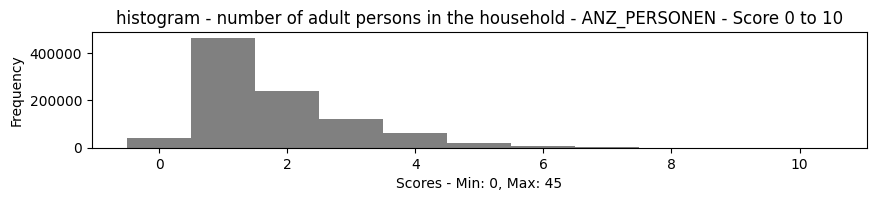

10 outliers (Score: %) 
 45: 0.0%, 40: 0.0%, 38: 0.0%, 37: 0.0%, 35: 0.0% … 8: 0.1%, 7: 0.2%, 6: 0.7%, 5: 2.3%, 4: 6.6%




In [45]:
'''
ANZ_PERSONEN  
- Value 0 might be strange or extreme but is possible
- outliers: household with over 10 adult persons is highly extreme or data error,
  that Value over 10 should be replaced to NaN
'''

view_feature (datasets, feature_desc, 'ANZ_PERSONEN', False)

In [46]:
'''
NOTE
'''

p_process['3.1.1-ANZ_PERSONEN'] = 'np.where / ANZ_PERSONEN / Score > 10 to -1'

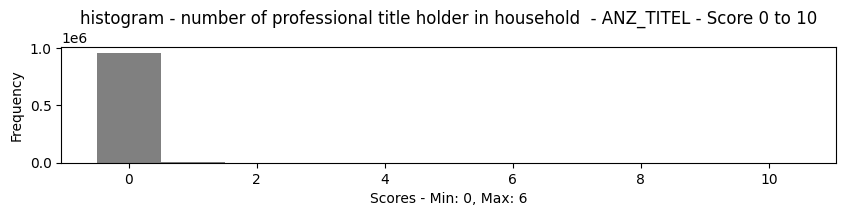

10 outliers (Score: %) 
 6: 0.0%, 5: 0.0%, 4: 0.0%, 3: 0.0%, 2: 0.0% … 5: 0.0%, 4: 0.0%, 3: 0.0%, 2: 0.0%, 1: 0.6%




In [47]:
'''
ANZ_TITEL
- it seems that there is no pre-processing needed.
  However, this feature is linked to ANZ_PERSONEN above
  that Score should be replaced to null if corresponding ANZ_PERSONEN is null.
'''

view_feature (datasets, feature_desc, 'ANZ_TITEL', False)

In [48]:
p_process['3.1.1-ANZ_TITEL'] = 'np.where / ANZ_TITEL / Score of ANZ_PERSONEN > 10 to -1'

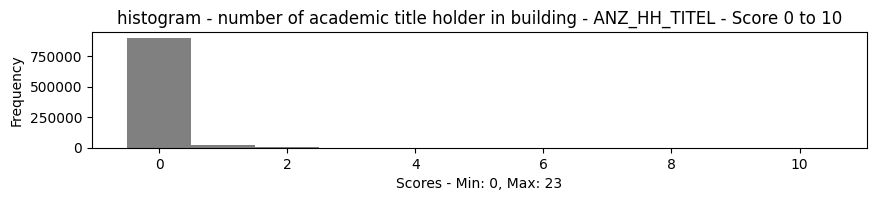

10 outliers (Score: %) 
 23: 0.0%, 20: 0.0%, 18: 0.0%, 17: 0.0%, 16: 0.0% … 5: 0.0%, 4: 0.0%, 3: 0.1%, 2: 0.3%, 1: 2.7%




In [49]:
'''
ANZ_HH_TITEL  
- No pre-processing needed: max values might be strange or extreme but are possible
'''

view_feature (datasets, feature_desc, 'ANZ_HH_TITEL', False)

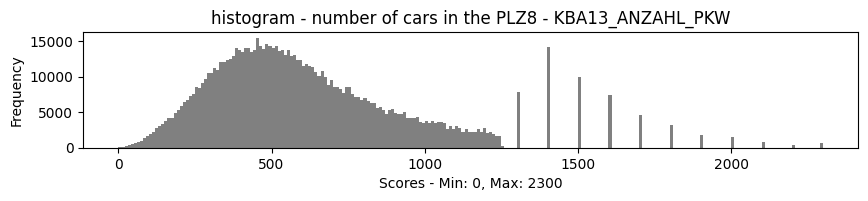

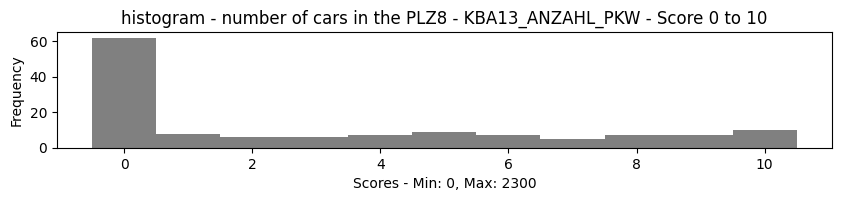

10 outliers (Score: %) 
 2300: 0.1%, 2200: 0.0%, 2100: 0.1%, 2000: 0.2%, 1900: 0.2% … 1800: 0.3%, 1700: 0.5%, 1600: 0.8%, 1500: 1.1%, 1400: 1.5%




In [50]:
'''
KBA13_ANZAHL_PKW
- in this feature values over 1250 is grouped by 100. 
  Log scaling is needed due to high skewness.
'''

view_feature (datasets, feature_desc, 'KBA13_ANZAHL_PKW')

In [51]:
p_process['3.1.1-KBA13_ANZAHL_PKW'] = 'log_scaling / KBA13_ANZAHL_PKW'

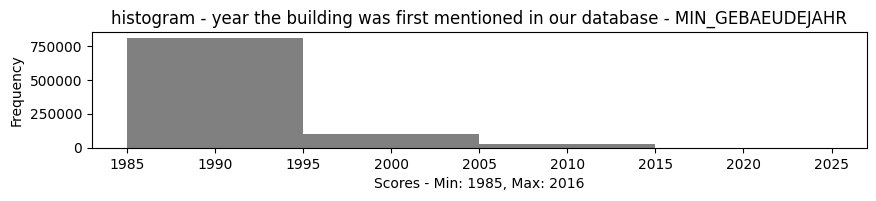

10 outliers (Score: %) 
 2016: 0.0%, 2015: 0.1%, 2014: 0.1%, 2013: 0.2%, 2012: 0.2% … 1989: 0.3%, 1988: 0.1%, 1987: 0.1%, 1986: 0.0%, 1985: 0.0%




In [52]:
'''
MIN_GEBAEUDEJAHR   
- No pre-processing needed
'''

view_feature (datasets, feature_desc, 'MIN_GEBAEUDEJAHR', True, False)

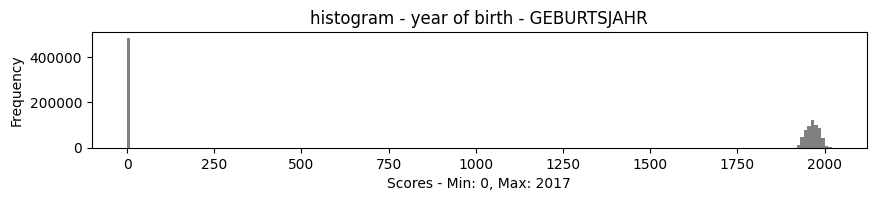

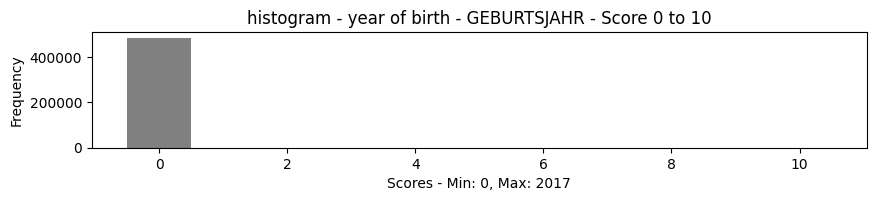

10 outliers (Score: %) 
  … 




In [53]:
'''
GEBURTSJAHR  
- outliers: birth year can not be 0 and anyone born before 1900 is extreme
  that Value < 1900 should be replaced to null
'''

view_feature (datasets, feature_desc, 'GEBURTSJAHR')

In [54]:
p_process['3.1.1-GEBURTSJAHR'] = 'np.where / GEBURTSJAHR / Score < 1900 to -1'

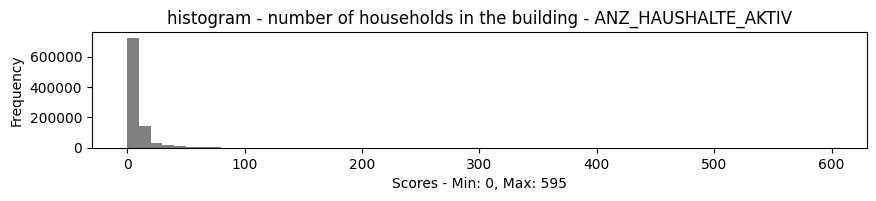

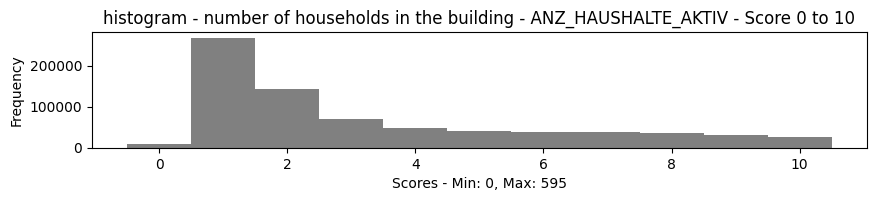

10 outliers (Score: %) 
 595: 0.0%, 536: 0.0%, 523: 0.0%, 515: 0.0%, 445: 0.0% … 26: 0.3%, 25: 0.3%, 24: 0.3%, 23: 0.4%, 22: 0.4%




In [55]:
'''
ANZ_HAUSHALTE_AKTIV  
- No pre-processing needed: Value 0 and max value might be strange or extreme but are possible
- Log scaling is needed due to high skewness
'''

view_feature (datasets, feature_desc, 'ANZ_HAUSHALTE_AKTIV')

In [56]:
'''
NOTE
'''

p_process['3.1.1-ANZ_HAUSHALTE_AKTIV'] = 'log_scaling / ANZ_HAUSHALTE_AKTIV'

##### 3.1.2 object dataset Scores of intersection features

In [57]:
'''
make datasets_obj_score containing summary of none-numeric Score values
'''

datasets_obj_score = dataset_summary(datasets, feature_desc, ['object'])

number of Attribute(s): 4


,Attribute,count,unique,top,freq,Desc,null_portion
0,CAMEO_DEU_2015,933466,45,6B,66306,CAMEO classification 2015 - detailled classification,0.137973
1,CAMEO_DEUG_2015,933466,19,8,87739,CAMEO classification 2015 - Uppergroup,0.137973
2,CAMEO_INTL_2015,933466,43,51,83563,CAMEO classification 2015 - international typology,0.137973
3,OST_WEST_KZ,939798,2,W,759910,flag indicating the former GDR/FRG,0.132125


In [58]:
'''
check if Scores in actual datasets are within range given by ref_attr.
'''

# merge min/max values by Attribute in attr_num_score in 2.3.1
for i in datasets_obj_score.Attribute.unique():
    score_in_datasets = set(datasets[i].unique())
    score_in_ref_attr = set(ref_attr.query('Attribute == "{}"'.format(i)).Score.values)
    
    print (i)
    print (f'a) scores in datasets: {score_in_datasets}')
    print (f'b) scores in ref_attr: {score_in_ref_attr}')
    print (f'a) b) intersection: {score_in_datasets.intersection(score_in_ref_attr)}')
    print (f'a) - b): {score_in_datasets - score_in_ref_attr}')
    print (f'b) - a): {score_in_ref_attr - score_in_datasets}', '\n')

CAMEO_DEU_2015
a) scores in datasets: {'6F', '2D', '9E', '4E', '6B', '6E', '5B', '6C', '3D', '8D', '5C', '8C', '2A', '4B', '2B', '5A', '1A', '1B', '7C', '9C', '9B', '5E', '2C', '6D', '8B', 'XX', '4A', '5D', '4C', '7E', nan, '7B', '6A', '3A', '7D', '1C', '9D', '7A', '1E', '1D', '8A', '3B', '9A', '3C', '4D', '5F'}
b) scores in ref_attr: {'6F', '2D', '9E', '4E', '6B', '6E', '5B', '3D', '6C', '8D', '5C', '2A', '8C', '4B', '2B', '5A', '1B', '1A', '5E', '7C', '9B', '9C', '2C', '6D', '8B', '4A', '4C', '5D', '7E', '7B', '6A', '3A', '7D', '1C', '9D', '7A', '1E', '1D', '8A', '3B', '9A', '3C', '4D', '5F'}
a) b) intersection: {'6F', '2D', '9E', '4E', '6B', '6E', '5B', '8D', '3D', '6C', '5C', '2A', '8C', '4B', '2B', '5A', '1B', '1A', '5E', '7C', '9B', '9C', '2C', '6D', '8B', '4A', '4C', '5D', '7E', '7B', '6A', '3A', '7D', '1C', '9D', '7A', '1E', '1D', '8A', '3B', '9A', '3C', '4D', '5F'}
a) - b): {nan, 'XX'}
b) - a): set() 

CAMEO_DEUG_2015
a) scores in datasets: {1.0, 2.0, 3.0, 4.0, 5.0, nan, 7.0, 

In [59]:
'''
2 features should have Score values in integer type.

missing value noted in 'XX', 'X' should be pre-processed. 
'''

none_numeric_in_datasets = ['CAMEO_DEU_2015', 'OST_WEST_KZ']

'''
NOTE
'''

p_process['3.1.2-CAMEO_INTL_2015XX'] = 'replace / CAMEO_INTL_2015 / {"XX": -1}'
p_process['3.1.2-CAMEO_DEU_2015'] = 'replace / CAMEO_DEU_2015 / {"XX": -1}'
p_process['3.1.2-CAMEO_DEUG_2015X'] = 'replace / CAMEO_DEUG_2015 / {"X": -1}'
p_process['3.1.2-dtype'] = 'astype / All features in numeric_discrete_features / change dtype to float'

#### 3.2 exclusive features NOT in reference files

In [60]:
'''
datasets_excl containing exclusive features of datasets
'''

datasets_excl = concat_data[
    list(feature_dict['in_customers_notin_ref_attr'])].copy()

##### 3.2.1 numeric dataset Scores of exclusive features

In [61]:
'''
make excl_num_score containing Scores denoted in number

from 57 features, most features have min/max gap 10 or lower,
which should be regarded as discrete.
'''

datasets_excl_num_score = dataset_summary(datasets_excl, feature_desc, ['int', 'float'])

number of Attribute(s): 57


,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat
0,CJT_TYP_4,1074806.0,3.525354,1.381115,1.0,2.0,4.0,5.0,5.0,CJT type 4,0.007450,1 to 5
1,KBA13_GBZ,925792.0,3.456625,1.107957,1.0,3.0,3.0,4.0,5.0,KBA13 GBZ,0.145059,1 to 5
2,KOMBIALTER,1082873.0,3.779872,2.225785,1.0,2.0,3.0,4.0,9.0,Combi,0.000000,1 to 9
3,ONLINE_PURCHASE,191652.0,0.090247,0.286536,0.0,0.0,0.0,0.0,1.0,Purchase online,0.823015,0 to 1
4,DSL_FLAG,939798.0,0.969232,0.172689,0.0,1.0,1.0,1.0,1.0,DSL flag,0.132125,0 to 1


min_max Scores: 
 ['1 to 5' '1 to 9' '0 to 1' '0 to 4' '4 to 18' '0 to 3' '2 to 18' '0 to 5'
 '0 to 25' '0 to 10' '0 to 45' '1 to 10' '1 to 11' '1 to 3'
 '1_900 to 2_018' '1 to 6' '0 to 2' '1 to 56' '7 to 18' '1 to 1_082_873'
 '11 to 50' '0 to 11' '0 to 449' '1 to 13']


* 6 continuous features

In [62]:
'''
from features with man/max gap over 10, 6 are found to be continuous
'''
# from datasets_excl_num_score above, extract Attribute values having min/max Score gap over 10
continuous_in_datasets_excl_attribute = datasets_excl_num_score[
    (datasets_excl_num_score['max'] - datasets_excl_num_score['min']) > 50].Attribute.unique()

# remove features with excessive missing values
continuous_in_datasets_excl = datasets_excl_num_score.query(
    'Attribute in @continuous_in_datasets_excl_attribute and null_portion < 0.5')
view_all(continuous_in_datasets_excl)

,Attribute,count,mean,std,min,25%,50%,75%,max,Desc,null_portion,min_max_cat
31,EINGEZOGENAM_HH_JAHR,962778.0,2003.044442,7.120764,1900.0,1997.0,2002.0,2009.0,2018.0,Intended HH year,0.110904,1_900 to 2_018
42,LNR,1082873.0,541437.000000,312598.653361,1.0,270719.0,541437.0,812155.0,1082873.0,LNR,0.000000,1 to 1_082_873
49,ANZ_STATISTISCHE_HAUSHALTE,939798.0,7.162317,14.347487,0.0,1.0,3.0,8.0,449.0,Anz statistical households,0.132125,0 to 449


In [63]:
'''
NOTE
Drop LNR, the serial index of dataset
'''

to_drop.append('LNR')

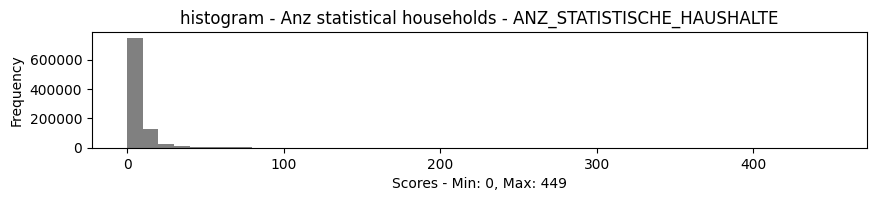

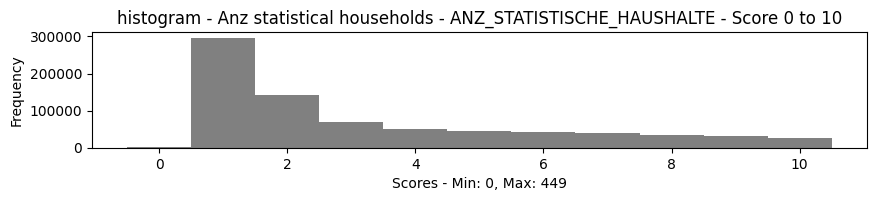

10 outliers (Score: %) 
 449: 0.0%, 445: 0.0%, 375: 0.0%, 371: 0.0%, 369: 0.0% … 23: 0.3%, 22: 0.4%, 21: 0.4%, 20: 0.4%, 19: 0.5%




In [64]:
'''
ANZ_STATISTISCHE_HAUSHALTE   
  - No pre-processing needed: Value 0 and max value might be strange or extreme but are possible
  - Log scaling is needed due to high skewness
'''

view_feature (datasets_excl, feature_desc, 'ANZ_STATISTISCHE_HAUSHALTE')

In [65]:
'''
NOTE
'''

p_process['3.2.1-ANZ_STATISTISCHE_HAUSHALTE'] = 'log_scaling / ANZ_STATISTISCHE_HAUSHALTE'

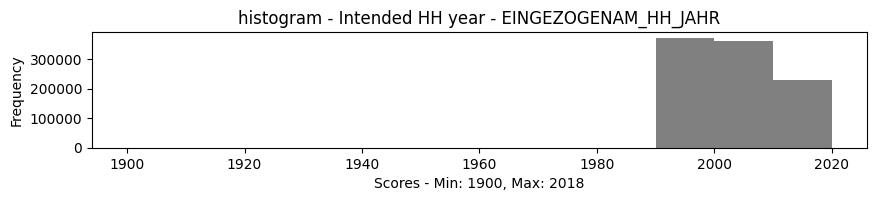

10 outliers (Score: %) 
 1971: 0.0%, 1904: 0.0%, 1900: 0.0% … 1971: 0.0%, 1904: 0.0%, 1900: 0.0%




In [66]:
'''
EINGEZOGENAM_HH_JAHR 
- outliers: Eng translation is not completely understandable, but 3 outliers can be replaced to null
'''

view_feature (datasets_excl, feature_desc, 'EINGEZOGENAM_HH_JAHR', True, False)

In [67]:
p_process['3.2.1-EINGEZOGENAM_HH_JAHR'] = 'np.where / EINGEZOGENAM_HH_JAHR / Score < 1980 to -1'

##### 3.2.2 object dataset Scores of exclusive features

In [68]:
'''
make datasets_excl_obj_score containing Scores denoted in obj
'''

datasets_excl_obj_score = dataset_summary(datasets_excl, feature_desc, ['object'])

number of Attribute(s): 4


,Attribute,count,unique,top,freq,Desc,null_portion
0,EINGEFUEGT_AM,939798,5254,1992-02-10 00:00:00,448482,Finded on,0.132125
1,PRODUCT_GROUP,191652,3,COSMETIC_AND_FOOD,100860,Product Group,0.823015
2,CUSTOMER_GROUP,191652,2,MULTI_BUYER,132238,Customer Group,0.823015
3,D19_LETZTER_KAUF_BRANCHE,778063,35,D19_UNBEKANNT,227248,D19 Last purchase industry,0.281483


In [69]:
'''
all 4 features are discrete
'''

none_numeric_in_datasets_excl = ['D19_LETZTER_KAUF_BRANCHE', 'CUSTOMER_GROUP', 'EINGEFUEGT_AM', 'PRODUCT_GROUP']

In [70]:
'''
NOTE
change dtype of EINGEFUEGT_AM to datetime only with year values
to minimize column number after one-hot encoding
'''

p_process['3.2.2-EINGEFUEGT_AM'] = 'astype / EINGEFUEGT_AM / change dtype to datetime only with year values'

In [71]:
'''
there is no abnormal Score value in datasets_excl_obj_score
'''

datasets_excl_obj_score = datasets_excl_obj_score.query('Attribute != "EINGEFUEGT_AM"')

for i in datasets_excl_obj_score.Attribute.unique():
    
    print (i)
    print (f'scores in datasets: {set(datasets_excl[i].unique())}', '\n')

PRODUCT_GROUP
scores in datasets: {'COSMETIC_AND_FOOD', 'COSMETIC', nan, 'FOOD'} 

CUSTOMER_GROUP
scores in datasets: {'MULTI_BUYER', nan, 'SINGLE_BUYER'} 

D19_LETZTER_KAUF_BRANCHE
scores in datasets: {'D19_VOLLSORTIMENT', 'D19_HANDWERK', 'D19_LOTTO', 'D19_BANKEN_REST', 'D19_HAUS_DEKO', 'D19_SCHUHE', 'D19_ENERGIE', 'D19_RATGEBER', 'D19_NAHRUNGSERGAENZUNG', 'D19_SAMMELARTIKEL', 'D19_KINDERARTIKEL', 'D19_BEKLEIDUNG_GEH', 'D19_KOSMETIK', 'D19_TECHNIK', 'D19_TELKO_MOBILE', 'D19_BANKEN_DIREKT', 'D19_BUCH_CD', 'D19_SONSTIGE', 'D19_TIERARTIKEL', 'D19_REISEN', nan, 'D19_BEKLEIDUNG_REST', 'D19_WEIN_FEINKOST', 'D19_VERSAND_REST', 'D19_FREIZEIT', 'D19_UNBEKANNT', 'D19_TELKO_REST', 'D19_BILDUNG', 'D19_BANKEN_LOKAL', 'D19_VERSICHERUNGEN', 'D19_DIGIT_SERV', 'D19_BIO_OEKO', 'D19_DROGERIEARTIKEL', 'D19_LEBENSMITTEL', 'D19_GARTEN', 'D19_BANKEN_GROSS'} 



### 4. Pre-processing

In this section datasets will be made ready for ML modeling in Part 1 and 2  
through the steps of categorizing items and creating objectives of pre-processing,  
executing pre-processing and dropping columns and rows with over 33% missing values.

#### 4.1 categorize pre-processing items

In [72]:
'''
create pre-processing items
'''
# transform p_process from dictionary to dataframe 
p_process_items = {'pre_processing_itmes' : p_process}
p_process_items = pd.DataFrame(p_process_items).reset_index()
p_process_items [['method', 'by_feature']] = p_process_items[
    'pre_processing_itmes'].str.split(' / ', n=1, expand=True)
p_process_items = p_process_items[['index', 'method', 'by_feature']].sort_values(['method', 'index'])
log_scaling_items = p_process_items.query('method == "log_scaling"')

view_all(p_process_items)

,index,method,by_feature
16,3.1.2-dtype,astype,All features in numeric_discrete_features / change dtype to float
19,3.2.2-EINGEFUEGT_AM,astype,EINGEFUEGT_AM / change dtype to datetime only with year values
0,2.3.1-drop,drop,All / drop features in to_drop
4,3.1.1-ANZ_HAUSHALTE_AKTIV,log_scaling,ANZ_HAUSHALTE_AKTIV
8,3.1.1-KBA13_ANZAHL_PKW,log_scaling,KBA13_ANZAHL_PKW
17,3.2.1-ANZ_STATISTISCHE_HAUSHALTE,log_scaling,ANZ_STATISTISCHE_HAUSHALTE
2,2.3.1-to_null,mask,All / replace Score to null if corresponding Meaning is in to_null
3,2.3.1-unknown_9,mask,category_small in unknown_9 / Score 9 to -1
5,3.1.1-ANZ_PERSONEN,np.where,ANZ_PERSONEN / Score > 10 to -1
6,3.1.1-ANZ_TITEL,np.where,ANZ_TITEL / Score of ANZ_PERSONEN > 10 to -1


#### 4.2 create reference objectives of pre-processing

In [73]:
'''
replacements dictionary
'''

p_process_replace = p_process_items.query('method == "replace"').iloc[1:]
p_process_replace[['col', 'dict_val']] = p_process_replace[
    'by_feature'].str.split(' / ', expand=True)

replacements = dict(map(lambda col, dict_val: (col, eval(dict_val)), 
                        p_process_replace['col'], p_process_replace['dict_val']))
replacements

{'LP_FAMILIE_FEIN': {0: -1},
 'LP_FAMILIE_GROB': {0: -1},
 'LP_LEBENSPHASE_FEIN': {0: -1},
 'LP_LEBENSPHASE_GROB': {0: -1},
 'CAMEO_DEUG_2015': {'X': -1},
 'CAMEO_DEU_2015': {'XX': -1},
 'CAMEO_INTL_2015': {'XX': -1}}

In [74]:
'''
mask to process Scores corresponding to Meaning in to_null
'''

mask_to_null = ref_attr.query('Meaning in (@to_null)')[['Attribute', 'Score']].set_index('Attribute')
mask_to_null = mask_to_null[mask_to_null.Score != -1]

features_unknown_9 = [i for i in feature_desc.Attribute.unique() if i.split('_')[0] in unknown_9]
mask_unknown_9 = pd.DataFrame(index = features_unknown_9, columns = ['Score'], data = 9)

In [75]:
'''
feature categorization
'''

# excl features of customers
customers_excl_discrete = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
all_features = list(
    x for x in feature_desc.Attribute.unique() if x not in customers_excl_discrete)

# continuous_features form 3.1.1 and 3.2.1
continuous_features = list(
    continuous_in_datasets.Attribute.unique()) + list(continuous_in_datasets_excl.Attribute.unique())

# discrete_features
discrete_features = list(x for x in all_features if x not in continuous_features)

# none_numeric_discrete_features form 3.1.2 and 3.2.2
none_numeric_discrete_features = none_numeric_in_datasets + none_numeric_in_datasets_excl
none_numeric_discrete_features = list(
    x for x in none_numeric_discrete_features if x not in customers_excl_discrete)

# numeric_discrete_features
numeric_discrete_features = list(
    x for x in discrete_features if x not in none_numeric_discrete_features)

#### 4.3 pre-processing

In [79]:
def pre_processing (data):
    '''
    function to pre_process datasets
    '''        
    # mask
    mask = data.eq(mask_to_null['Score'], axis=1)
    data = data.mask(mask)
    
    mask = data.eq(mask_unknown_9['Score'], axis=1)
    data = data.mask(mask)

    # np.where
    data['ANZ_PERSONEN'] = np.where(data['ANZ_PERSONEN'] > 10, -1, data['ANZ_PERSONEN'])
    data['ANZ_TITEL'] = np.where(data['ANZ_PERSONEN'] > 10, -1, data['ANZ_TITEL'])
    data['GEBURTSJAHR'] = np.where(data['GEBURTSJAHR'] < 1900, -1, data['GEBURTSJAHR'])
    data['EINGEZOGENAM_HH_JAHR'] = np.where(data['EINGEZOGENAM_HH_JAHR'] < 1980, -1, data['EINGEZOGENAM_HH_JAHR'])

    # replacement
    data = data.replace(replacements)
    data = data.replace(-1, np.nan)

    # astype
    data[numeric_discrete_features] = data[numeric_discrete_features].astype(float)
    data['EINGEFUEGT_AM'] = pd.to_datetime(data['EINGEFUEGT_AM'], format = '%Y-%m-%d').dt.year 
    
    # drop
    data = data.drop(to_drop, axis = 1)

    return data

In [80]:
org_azdias = azdias.copy()
azdias = pre_processing (azdias)

In [81]:
org_customers = customers.copy()
# to avoid column mismatch between 2 datasets
customers = customers[list(i for i in customers.columns if i not in (customers_excl_discrete))]
customers = pre_processing (customers) 

#### 4.4 columns with missing values over threshold

% of missing value in 361 columns of azdias
mean    11.696800
std     13.839740
min      0.000000
25%      0.544646
50%     11.871354
75%     13.073637
max     99.864792


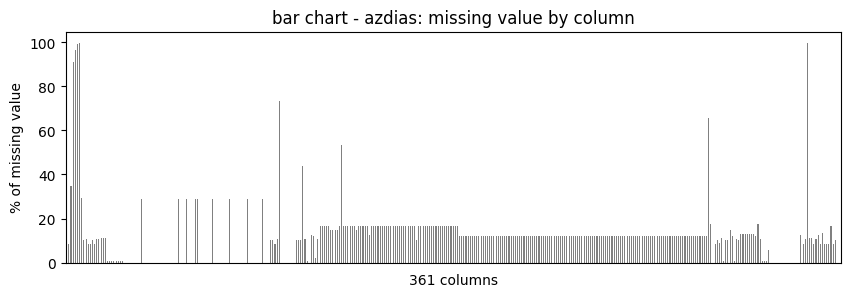

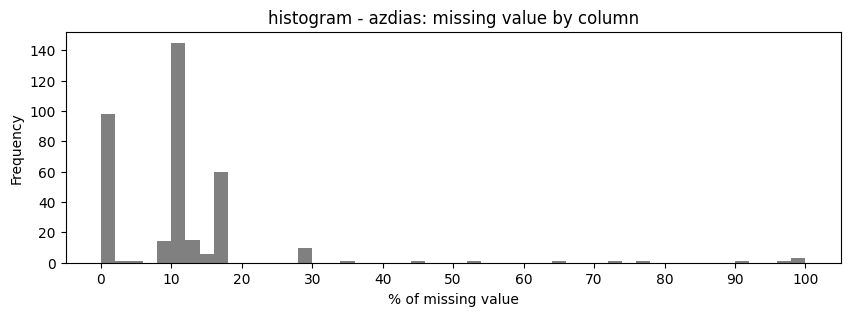

In [82]:
'''
missing column overview: azdias
'''

azdias.name = 'azdias'
miss_val_summary (azdias)

% of missing value in 361 columns of customers
mean    21.199942
std     15.607324
min      0.000000
25%      1.676476
50%     26.757352
75%     26.757352
max     99.876860


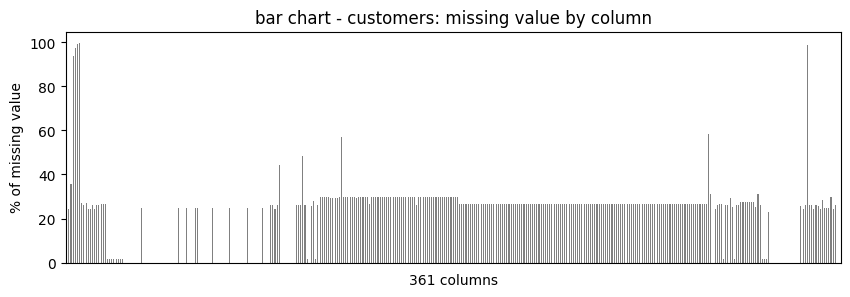

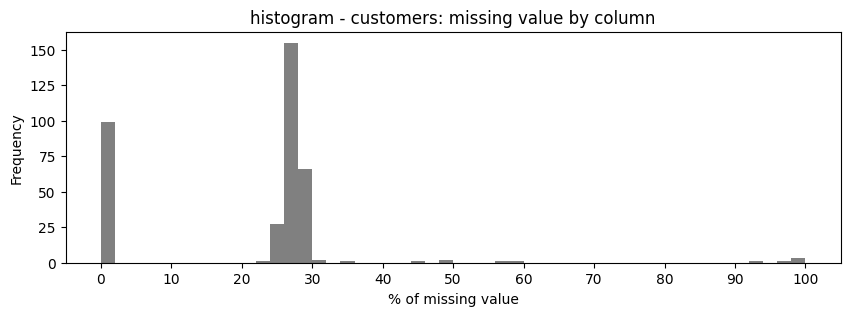

In [83]:
'''
missing column overview: customers
'''

customers.name = 'customers'
miss_val_summary (customers)

In [84]:
'''
find columns of azdias with missing values over 33%
'''

temp_missing_col = azdias.isnull().mean()
azdias_missing_col = list(temp_missing_col[temp_missing_col > 0.33].index)
print ('azdias missing columns:', azdias_missing_col)

temp_missing_col = customers.isnull().mean()
customers_missing_col = list(temp_missing_col[temp_missing_col > 0.33].index)
print ('customers missing columns:', customers_missing_col)

azdias missing columns: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']
customers missing columns: ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


#### 4.5 rows with missing values over threshold

% of missing value in 891221 rows of azdias
mean    11.696800
std     21.230796
min      0.277008
25%      1.939058
50%      2.770083
75%      5.540166
max     72.576177


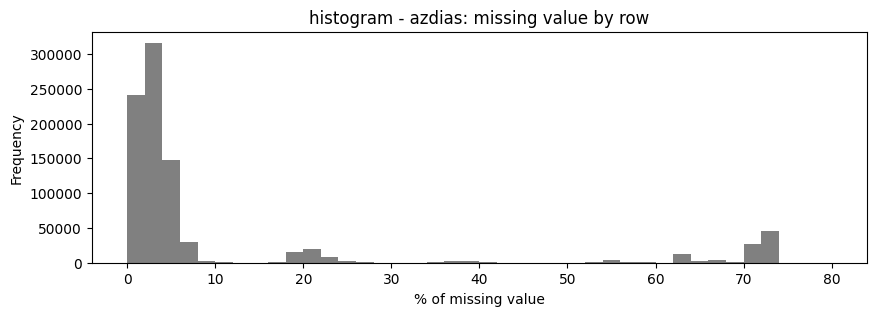

In [85]:
'''
missing row overview: azdias
'''

azdias.name = 'azdias'
miss_val_summary (azdias, axis_val = 'row', bar_chart = False)

% of missing value in 191652 rows of customers
mean    21.199942
std     30.512569
min      0.277008
25%      1.662050
50%      2.216066
75%     63.157895
max     72.576177


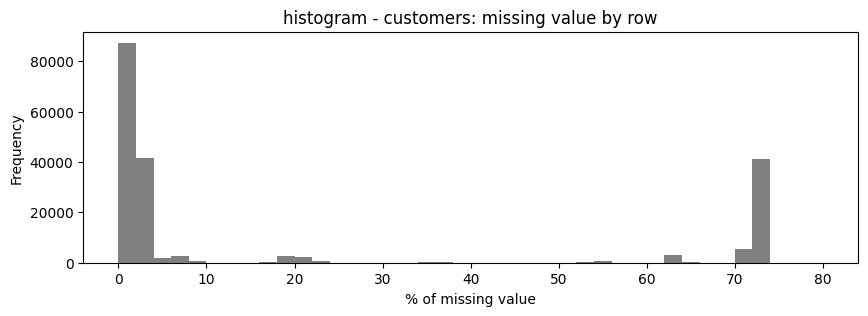

In [86]:
'''
missing row overview: customers
'''

customers.name = 'customers'
miss_val_summary (customers, axis_val = 'row', bar_chart = False)

#### 4.6 drop columns and rows

In [87]:
def drop_miss_val (data, col, threshold):
    '''
    function to drop columns and rows with missing values
    data: dataframe
    col: str / list, columns to drop
    threshold : float, threshold for dropping rows
    '''
    # drop columns
    data = data.drop(col, axis = 1)
    
    # drop rows
    temp_missing_row = data.isnull().sum(axis = 1) / data.shape[1]
    temp_missing_row = temp_missing_row > threshold
    data = data[~temp_missing_row]
    
    return data

In [88]:
azdias = drop_miss_val(azdias, customers_missing_col, 0.33)
customers = drop_miss_val(customers, customers_missing_col, 0.33)

* save pre-processed datasets as parquet

In [89]:
# table = pa.Table.from_pandas(azdias)
# pq.write_table(table, '../data/azdias.parquet')

In [90]:
# table = pa.Table.from_pandas(customers)
# pq.write_table(table, '../data/customers.parquet')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

* load pre-processed datasets and feature category lists 

In [91]:
# azdias = pq.read_table('../data/azdias.parquet').to_pandas()
# azdias.shape

In [92]:
# customers = pq.read_table('../data/customers.parquet').to_pandas()
# customers.shape

### 1. Dataset transformation

* modify feature category

In [93]:
# modify feature category
log_scaling_features = list(log_scaling_items.by_feature.values) # see 4.1
continuous_features = [i for i in continuous_features if i not in (log_scaling_features)]

features_to_remove = to_drop + customers_missing_col # see 4.4
    
log_scaling_features = [x for x in log_scaling_features if x not in features_to_remove]
continuous_features = [x for x in continuous_features if x not in features_to_remove]
discrete_features = [x for x in discrete_features if x not in features_to_remove]
none_numeric_discrete_features = [x for x in none_numeric_discrete_features if x not in features_to_remove]
numeric_discrete_features = [x for x in numeric_discrete_features if x not in features_to_remove]

* transformation pipelines  
  make column_transformer composed of 4 pipelines based on feature categorization in 4.5 

In [94]:
'''log_scaling_features'''

log_scaling_pipeline = make_pipeline(
    FunctionTransformer(np.log1p),
    SimpleImputer(missing_values = np.nan, strategy = 'median'),
    StandardScaler()
)

In [95]:
'''continuous_features'''

continuous_pipeline = make_pipeline(
    SimpleImputer(missing_values = np.nan, strategy = 'median'),
    StandardScaler()
)

In [96]:
'''numeric_discrete_features'''

numeric_discrete_pipeline = make_pipeline(
    SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'),
    StandardScaler()
)

In [97]:
'''none_numeric_discrete_features'''

none_numeric_discrete_pipeline = make_pipeline(
    SimpleImputer(missing_values = np.nan, strategy = 'most_frequent'),
    OneHotEncoder(handle_unknown = 'ignore')  
)

In [98]:
'''combined pipeline'''

column_transformer = make_column_transformer(
    (log_scaling_pipeline, log_scaling_features),
    (continuous_pipeline, continuous_features),
    (numeric_discrete_pipeline, numeric_discrete_features),
    (none_numeric_discrete_pipeline, none_numeric_discrete_features)
)

* dataset transformation

In [99]:
'''azdias_tf'''

azdias_tf = column_transformer.fit_transform(azdias)
azdias_tf.shape

(785421, 450)

In [100]:
'''customers_tf'''

customers_tf = column_transformer.transform(customers)
customers_tf.shape

(140371, 450)

### 2. PCA

* find principal components for 95% explained variance

In [101]:
pca = PCA()
azdias_pca = pca.fit(azdias_tf)

Number of principal components for 95% explained variance: 227


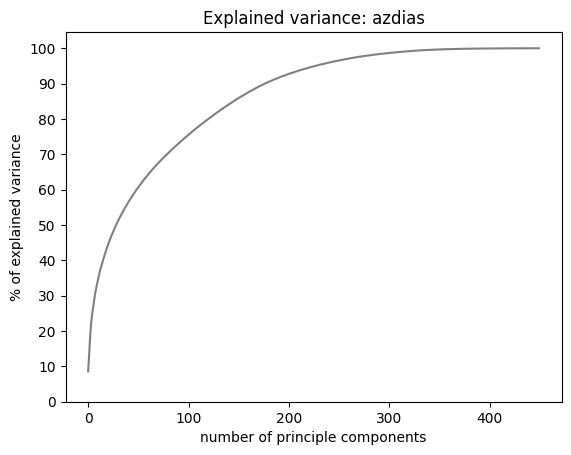

In [102]:
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100, color = 'grey')
plt.title('Explained variance: azdias')
plt.xlabel('number of principle components')
plt.ylabel('% of explained variance')
plt.yticks(np.arange(0, 110, 10));

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print('Number of principal components for 95% explained variance:',
      np.argmax(cumulative_variance >= 0.95) + 1)

# plt.savefig('explained_variance.png', dpi = 500);

* dimension reduction with 227 components

In [103]:
pca = PCA(n_components = 227)
azdias_227 = pd.DataFrame(pca.fit_transform(azdias_tf))
customers_227 = pd.DataFrame(pca.transform(customers_tf))

# # save reduced datasets as parquet
# table = pa.Table.from_pandas(azdias_228)
# pq.write_table(table, '../data/azdias_228.parquet')

# table = pa.Table.from_pandas(customers_228)
# pq.write_table(table, '../data/customers_228.parquet')

### 3. Clustering

* load reduced datasets

In [104]:
# azdias_227 = pq.read_table('../data/azdias_227.parquet').to_pandas()
# azdias_227.shape

In [105]:
# customers_227 = pq.read_table('../data/customers_227.parquet').to_pandas()
# customers_227.shape

* select the best number of clusters by elbow method

100%|██████████| 25/25 [05:26<00:00, 13.06s/it]


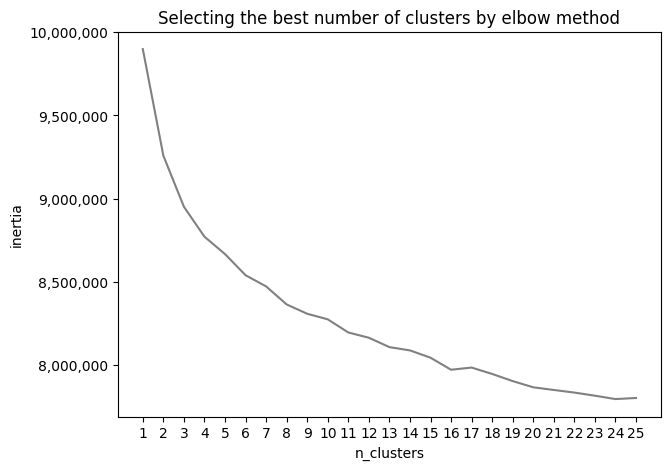

In [106]:
inertia_list = []
for i in tqdm(range(1, 26)):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', n_init = 10, random_state = 0)
    kmeans.fit(azdias_227.sample(30000))
    inertia_list.append(kmeans.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(range(1, 26), inertia_list, color = 'grey')
plt.title('Selecting the best number of clusters by elbow method')
plt.xlabel('n_clusters')
plt.xticks(list(range(1, 26)))
plt.ylabel('inertia')
plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.savefig('cluster_number_elbow.png', dpi = 500);
# Image ('cluster_number_elbow.png', width = 600, height = 400)

* create cluster labels:  
  general_label for general population and customer_label for the customers of the company

In [107]:
'''
use KMeans clustering with 8 clusters 
'''

kmeans = KMeans(n_clusters = 8, n_init = 10, random_state=0)

In [108]:
'''
create cluster labels of general population
'''

general_label = kmeans.fit_predict(azdias_227)
general_label

array([4, 4, 6, ..., 4, 3, 6], dtype=int32)

In [109]:
'''
create cluster labels of customers of the company
'''

customers_label = kmeans.predict(customers_227)
customers_label

array([6, 5, 6, ..., 6, 1, 1], dtype=int32)

* Visualize clusters  
  Out of 9 clusters, approx. 91% of the company's customers are in 4 clusters

In [110]:
def cluster_df (label_data, col_name):
    '''
    function to create a dataframe showing sample number and portion by each cluster label_data 
    label_data: array of clustering labels
    col_name: str, column name used in data frame
    '''

    df = pd.Series(label_data).value_counts().sort_index().reset_index()
    df.columns = ['label', col_name]
    df = df.reset_index(drop=True)    
    df[col_name + '_pct'] = (df[col_name] / df[col_name].sum() * 100).round(1)
    df = df.drop(col_name, axis = 1)
    
    return df

In [111]:
'''
create comparison table between general population and customers of the company

Out of 9 clusters, approx. 91% of the company's customers are in 4 clusters
'''

general_cluster = cluster_df (general_label, 'general_population')
customers_cluster = cluster_df (customers_label, 'customers')
cluster_summary = vlookup(general_cluster, customers_cluster)
cluster_summary

,label,general_population_pct,customers_pct
0,0,8.7,3.6
1,1,16.4,26.9
2,2,8.2,2.2
3,3,12.3,2.1
4,4,15.6,1.0
5,5,13.0,12.2
6,6,15.7,26.7
7,7,10.1,25.3


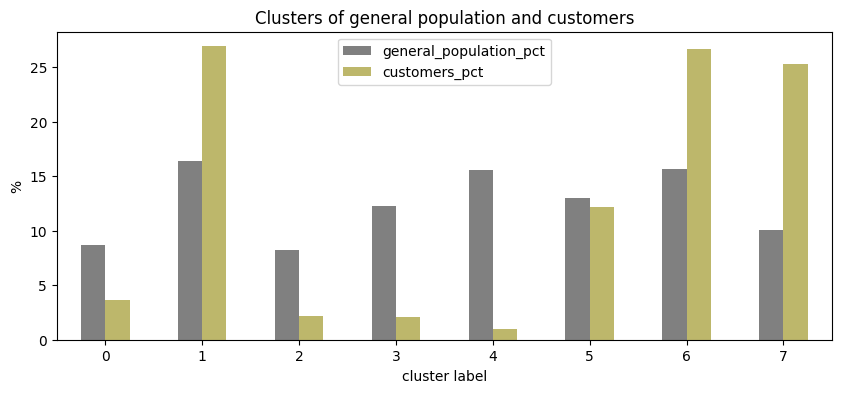

In [112]:
'''
create comparison plot between general population and customers of the company
'''

cluster_summary.plot(
    kind = 'bar', figsize=(10, 4),
    x = 'label',
    y = ['general_population_pct', 'customers_pct'],
    color = ['grey', 'darkkhaki'],
    # color='gray',
    title = 'Clusters of general population and customers',
    ylabel = '%',
    xlabel = 'cluster label',
    # xticks = clusters.label,
    );
plt.xticks(rotation=0);
plt.savefig('cluster_chart.png', dpi = 500);

In [ ]:
stop

* find feature importance in clustering

In [135]:
'''
to find out important features in clustering
retrieve column names of datasets
'''

retrieved_column_list = []
for i in column_transformer.transformers_:
    transformer = i[1].steps[-1][1]    
    transformer_columns = i[2]
    if isinstance(transformer, OneHotEncoder):
        retrieved_column = transformer.get_feature_names_out(transformer_columns)    
    else:
        retrieved_column = transformer_columns
    retrieved_column_list.extend(retrieved_column)

df_customers_tf = pd.DataFrame(customers_tf, columns = retrieved_column_list)
df_customers_tf

AttributeError: 'str' object has no attribute 'steps'

In [114]:
'''
get feature importance using DecisionTreeClassifier
'''

dt = DecisionTreeClassifier(max_depth = 10)
dt.fit(df_azdias_tf, general_label)

feature_importance = dt.feature_importances_

dict_feature_importance = dict()
for i, j in zip(df_azdias_tf.columns, feature_importance):
    dict_feature_importance[i] = j

In [115]:
'''
extract features of 85% feature importance
'''

df_feature_importance = {'feature_importance': dict_feature_importance}
df_feature_importance = pd.DataFrame(
    df_feature_importance).sort_values('feature_importance', ascending = False).reset_index().rename(columns={'index': 'Attribute'})
df_feature_importance['importance_pct'] = (df_feature_importance['feature_importance'] * 100).round(1)
df_feature_importance['cumulative__importance_pct'] = df_feature_importance['importance_pct'].cumsum()
df_feature_importance = df_feature_importance.query('cumulative__importance_pct < 85.1')
df_feature_importance

,Attribute,feature_importance,importance_pct,cumulative__importance_pct
0,CJT_TYP_2,0.164710,16.5,16.5
1,D19_GESAMT_ANZ_24,0.135757,13.6,30.1
2,LP_STATUS_FEIN,0.133619,13.4,43.5
3,KBA13_ANTG1,0.112329,11.2,54.7
4,KBA13_SITZE_4,0.056655,5.7,60.4
5,KBA13_HERST_BMW_BENZ,0.047925,4.8,65.2
6,KBA13_ANTG3,0.028926,2.9,68.1
7,D19_GESAMT_DATUM,0.022358,2.2,70.3
8,OST_WEST_KZ_O,0.022164,2.2,72.5
9,EWDICHTE,0.017200,1.7,74.2


* find characteristics of clusters

In [116]:
'''
all important features are discrete
'''

feature_high_importance = list(df_feature_importance.Attribute.unique())
set(feature_high_importance) - set(numeric_discrete_features)

{'OST_WEST_KZ_O'}

In [118]:
'''
find out what scores each cluster has on important features
'''

feature_high_importance = [x for x in feature_high_importance if x not in ['OST_WEST_KZ_O', 'OST_WEST_KZ_W']]
feature_high_importance.append('OST_WEST_KZ')

# to azdias add cluster label
azdias_with_cluster = azdias.loc[:, feature_high_importance].copy()
azdias_with_cluster['cluster'] = general_label
azdias_with_cluster['cluster'] = 'cluster_' + azdias_with_cluster['cluster'].astype(str)
azdias_with_cluster['OST_WEST_KZ'] = azdias_with_cluster['OST_WEST_KZ'].replace({'W': 1, 'O': 0})

# find out what scores each cluster has on important features
cluster_score = pd.pivot_table(azdias_with_cluster,
                               columns = 'cluster',
                               aggfunc = pd.Series.mode)
cluster_score = cluster_score.round(0).astype(int)
cluster_score.loc['OST_WEST_KZ'] = cluster_score.loc['OST_WEST_KZ'].replace({1: 'W', 0: 'O'})

cluster_score

cluster,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
CAMEO_DEUG_2015,8,4,8,9,4,8,4,1
CJT_TYP_2,5,4,2,5,4,2,1,2
D19_GESAMT_ANZ_24,4,4,0,0,0,0,0,0
D19_GESAMT_DATUM,1,1,10,10,10,10,10,10
D19_GESAMT_ONLINE_QUOTE_12,10,10,0,0,0,0,0,0
EWDICHTE,6,2,6,6,2,6,2,5
FINANZ_SPARER,5,2,1,5,5,1,1,1
KBA13_ALTERHALTER_45,3,3,3,5,3,3,3,3
KBA13_ANTG1,2,3,1,1,2,2,3,2
KBA13_ANTG3,2,1,3,3,1,2,1,2


In [121]:
'''
complete the table of cluster characteristics
with Meaning values corresponding to Score values
'''

# create mapping dictionary
mapping_dict = dict(zip(ref_attr['Attribute'] + ref_attr['Score'].astype(str), ref_attr['Meaning']))

# replace Score values to Meaning Values
cluster_meaning = cluster_score.copy().astype(str)
cluster_meaning = pd.DataFrame(
    np.repeat(cluster_meaning.index.values[:, None], cluster_meaning.shape[1], axis=1) + cluster_meaning.values,
    index = cluster_meaning.index, columns = cluster_meaning.columns)

cluster_meaning = cluster_meaning.replace(mapping_dict)
cluster_meaning['Attribute'] = cluster_meaning.index
cluster_meaning = vlookup(cluster_meaning, df_feature_importance, left_key = 'Attribute', lookup_col = 'importance_pct')
cluster_meaning = vlookup(cluster_meaning, feature_desc, left_key = 'Attribute', lookup_col = 'Description')

col_1 = list(cluster_meaning.columns[-3:])
col_2 = list(cluster_meaning.columns[:-3])
cluster_meaning = cluster_meaning[col_1 + col_2]

cluster_meaning.importance_pct = np.where(cluster_meaning.Attribute == 'OST_WEST_KZ',
                                          df_feature_importance.query('Attribute.str.contains("OST_WEST_KZ")').importance_pct.sum(),
                                          cluster_meaning.importance_pct)
cluster_meaning = cluster_meaning.sort_values('importance_pct', ascending = False)

null_cell_condition = cluster_meaning['Description'].isnull()
cluster_meaning.loc[null_cell_condition, cluster_meaning.columns[2:]] = np.nan

col_to_display = ['Attribute', 'importance_pct', 'Description',
                  'cluster_1', 'cluster_5', 'cluster_6', 'cluster_7']
view_all(cluster_meaning[col_to_display][:10])

,Attribute,importance_pct,Description,cluster_1,cluster_5,cluster_6,cluster_7
1,CJT_TYP_2,16.5,NaN,NaN,NaN,NaN,NaN
2,D19_GESAMT_ANZ_24,13.6,transaction activity TOTAL POOL in the last 24 months,increased activity,no transactions known,no transactions known,no transactions known
15,LP_STATUS_FEIN,13.4,social status fine,houseowners,typical low-income earners,houseowners,top earners
8,KBA13_ANTG1,11.2,NaN,NaN,NaN,NaN,NaN
14,KBA13_SITZE_4,5.7,number of cars with less than 5 seats in the PLZ8,average,average,average,very high
11,KBA13_HERST_BMW_BENZ,4.8,share of BMW & Mercedes Benz within the PLZ8,average,average,average,very high
9,KBA13_ANTG3,2.9,NaN,NaN,NaN,NaN,NaN
3,D19_GESAMT_DATUM,2.2,actuality of the last transaction with the complete file TOTAL,highest activity within the last 12 months,no transactions known,no transactions known,no transactions known
16,OST_WEST_KZ,2.2,flag indicating the former GDR/FRG,West (FRG),West (FRG),West (FRG),West (FRG)
5,EWDICHTE,1.7,density of inhabitants per square kilometer,34 - 89 HH/km²,more than 999 HH/²,34 - 89 HH/km²,320 - 999 HH/km²


In [ ]:
stop

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

* load data check imbalance

In [123]:
mailout_train = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(6)
memory usage: 120.3+ MB


/var/folders/y5/wyn61d3n7wxdpg5j1f0rpvc80000gn/T/ipykernel_1227/3860380851.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [124]:
'''
check target imbalance

In that the target is extremely imbalanced and the minority class is of particular interest (1),
ROC-AUC is chosen as the evaluation metric of classifiers, because it takes into account
the trade-off between true positive rate (sensitivity) and false positive rate,
which is essential when dealing with imbalanced data.
'''

mailout_train.RESPONSE.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

* preprocessing and drop columns / rows

In [125]:
'''
pre-procssing
'''

org_mailout_train = mailout_train.copy()
mailout_train = pre_processing (mailout_train)

% of missing value in 362 columns of mailout_train
mean    15.345644
std     13.608815
min      0.000000
25%      1.408221
50%     18.532657
75%     18.866091
max     99.904567


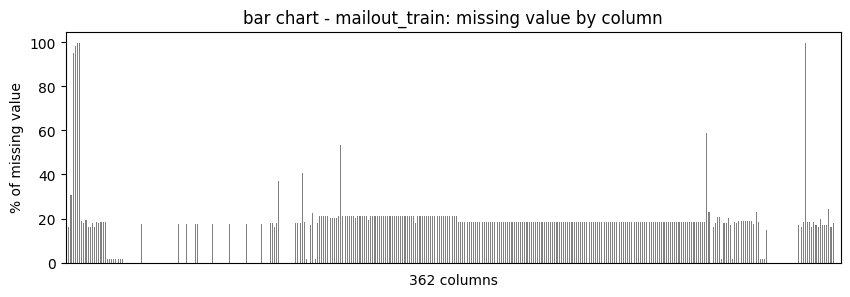

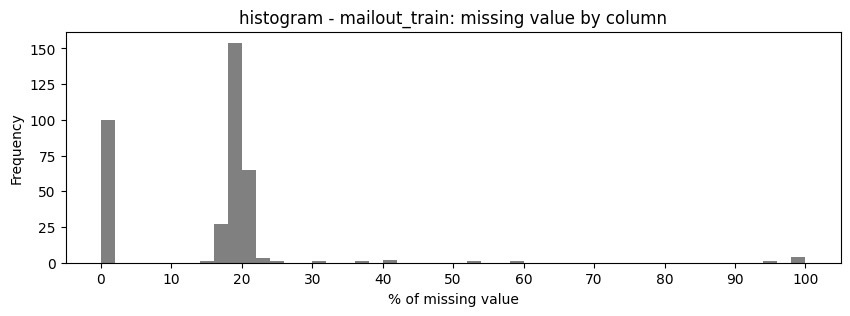

In [126]:
'''
missing column overview: mailout_train
'''

mailout_train.name = 'mailout_train'
miss_val_summary (mailout_train)

In [127]:
'''
find columns of mailout_train with missing values over 33%
'''

temp_missing_col = mailout_train.isnull().mean()
mailout_train_missing_col = list(temp_missing_col[temp_missing_col > 0.33].index)
print ('mailout_train missing columns:', mailout_train_missing_col)

mailout_train missing columns: ['AGER_TYP', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'KK_KUNDENTYP', 'TITEL_KZ']


% of missing value in 42962 rows of mailout_train
mean    15.345644
std     26.651597
min      0.276243
25%      1.657459
50%      2.209945
75%      3.867403
max     72.375691


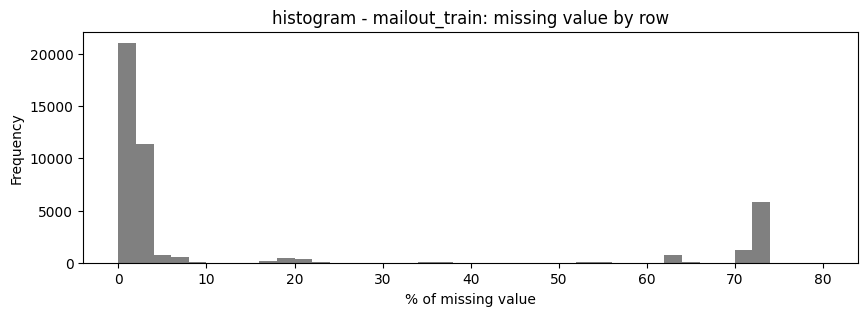

In [128]:
'''
missing row overview: mailout_train
'''

mailout_train.name = 'mailout_train'
miss_val_summary (mailout_train, axis_val = 'row', bar_chart = False)

In [129]:
'''
drop missing values
'''

mailout_train = drop_miss_val(mailout_train, mailout_train_missing_col, 0.33)
# mailout_test = drop_miss_val(mailout_test, mailout_train_missing_col, 0.33)

* dataset transformation

In [130]:
'''
modify feature category
'''

features_to_remove = to_drop + mailout_train_missing_col 
# see above find columns of mailout_train with missing values over 33%
    
log_scaling_features = [x for x in log_scaling_features if x not in features_to_remove]
continuous_features = [x for x in continuous_features if x not in features_to_remove]
discrete_features = [x for x in discrete_features if x not in features_to_remove]
none_numeric_discrete_features = [x for x in none_numeric_discrete_features if x not in features_to_remove]
numeric_discrete_features = [x for x in numeric_discrete_features if x not in features_to_remove]

In [131]:
X = mailout_train.drop('RESPONSE', axis = 1)  # Features
y = mailout_train.RESPONSE

In [132]:
X = column_transformer.fit_transform(X)

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

* initial testing on classifiers

In [134]:
classifiers = [
    RandomForestClassifier(random_state = 0),
    AdaBoostClassifier(random_state = 0),
    GradientBoostingClassifier(random_state = 0)
]

# define the parameter grid for GridSearchCV
param_grids = [
    {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5, 10]
    },
    {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 1.0],
        'algorithm': ['SAMME', 'SAMME.R']
    },
    {
        'n_estimators': [50, 100],
        'learning_rate': [0.1, 0.5],
        'max_depth': [3, 5]
    }
]

# Perform GridSearchCV
for i, j in zip(classifiers, param_grids):
    grid_search = GridSearchCV(i, j,
                               cv = KFold(n_splits = 5, shuffle = True, random_state = 0),
                               scoring = 'roc_auc', verbose = 1, n_jobs = -1)
    
    # execute grid search and get the best model
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    # make prediction using the best model
    y_pred = best_model.predict(X_test)
    
    # calculate ROC_AUC score
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    print("Classifier:", i.__class__.__name__)
    print("Best parameters:", grid_search.best_params_)
    print("ROC AUC:", roc_auc, '\n')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Classifier: RandomForestClassifier
Best parameters: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
ROC AUC: 0.7512606714734374 

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classifier: AdaBoostClassifier
Best parameters: {'algorithm': 'SAMME', 'learning_rate': 1.0, 'n_estimators': 200}
ROC AUC: 0.8119142055312267 

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Classifier: GradientBoostingClassifier
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
ROC AUC: 0.8036768355917292 



* GradientBoostingClassifier

In [ ]:
clf = GradientBoostingClassifier(random_state = 0)

# define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [30, 50],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, None],
    'min_samples_split': [2, 5, 10]
}

# Perform GridSearchCV
grid_search = GridSearchCV(clf, param_grid,
                            cv = KFold(n_splits = 5, shuffle = True, random_state = 0),
                            scoring = 'roc_auc', verbose = 2, n_jobs = -1)

grid_search = GridSearchCV(clf, param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                           scoring='roc_auc', verbose=2, n_jobs=-1)

# execute grid search and get the best model
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# make prediction using the best model
y_pred = best_model.predict(X_test)

# calculate ROC_AUC score
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Classifier:", i.__class__.__name__)
print("Best parameters:", grid_search.best_params_)
print("ROC AUC:", roc_auc, '\n')

In [ ]:
stop

In [ ]:
import imgkit

def df_to_image(df,title, width, height, name_file):
    
    # Set desired font-family and font-size
    font_style = 'Helvetica Neue'
    font_size = '12px'
    table_width = width
    table_height = height
    
    df = df.style.set_table_styles(
        [dict(selector='th', 
              props=[('text-align', 'left'), ('background-color', 'gray'), ('color', 'white')])]
            #   props=[('text-align', 'left'), ('background-color', '#40466e'), ('color', 'white')])
        )
    df.set_properties(**{'text-align': 'left'}).hide(axis='index')
    pd.set_option('colheader_justify', 'left')

    # Modify the HTML template with font styling
    html_template = f"""
    <html>
    <head>
        <title>"aaa"</title>
        <style>
            body {{
                font-family: {font_style};
                font-size: {font_size};
            }}
            table {{
                font-family: {font_style};
                font-size: {font_size};
                width: {table_width};
                height: {table_height};
            }}
            .table-title {{
            font-weight: bold;
            font-size: 18px;
            margin-bottom: 10px;
            }}
        </style>
    </head>
    <body>
        <h1 class="table-title">{title}</h1>
        {df.to_html()}
    </body>
    </html>
    """

    imgkit.from_string(html_template, name_file + ".png")

    # df = df.style.set_table_styles(
    #     [dict(selector='th', 
    #           props=[('text-align', 'center'),('background-color', '#40466e'),('color', 'white')])])
    # df.set_properties(**{'text-align': 'center'}).hide(axis='index')
    # pd.set_option('colheader_justify', 'center')

    # html = df.to_html()
    # imgkit.from_string(html, name_file + ".png")

In [ ]:
p_process_items_md = df_to_image(p_process_items, "Preprocessing Items Summarized", '80%', '120%', 'p_process_items_md')

In [ ]:
Image ('p_process_items_md.png')

In [ ]:
p_process_items_md 

In [ ]:
p_process_items_md = p_process_items.to_markdown(index=False)
print (p_process_items_md)

In [ ]:
cluster_meaning_md = cluster_meaning.to_markdown(index = False)
print (cluster_meaning_md)

end of workbook